Processing result: n_train=20000, hidden_size=200
Processing result: n_train=100, hidden_size=200
Processing result: n_train=15000, hidden_size=200
Processing result: n_train=50, hidden_size=200
Processing result: n_train=10000, hidden_size=200
Processing result: n_train=10, hidden_size=200
Processing result: n_train=8000, hidden_size=200
Processing result: n_train=5000, hidden_size=200
Processing result: n_train=2500, hidden_size=200
Processing result: n_train=1000, hidden_size=200
Processing result: n_train=800, hidden_size=200
Processing result: n_train=500, hidden_size=200
Processing result: n_train=400, hidden_size=200
Processing result: n_train=300, hidden_size=200
Processing result: n_train=200, hidden_size=200


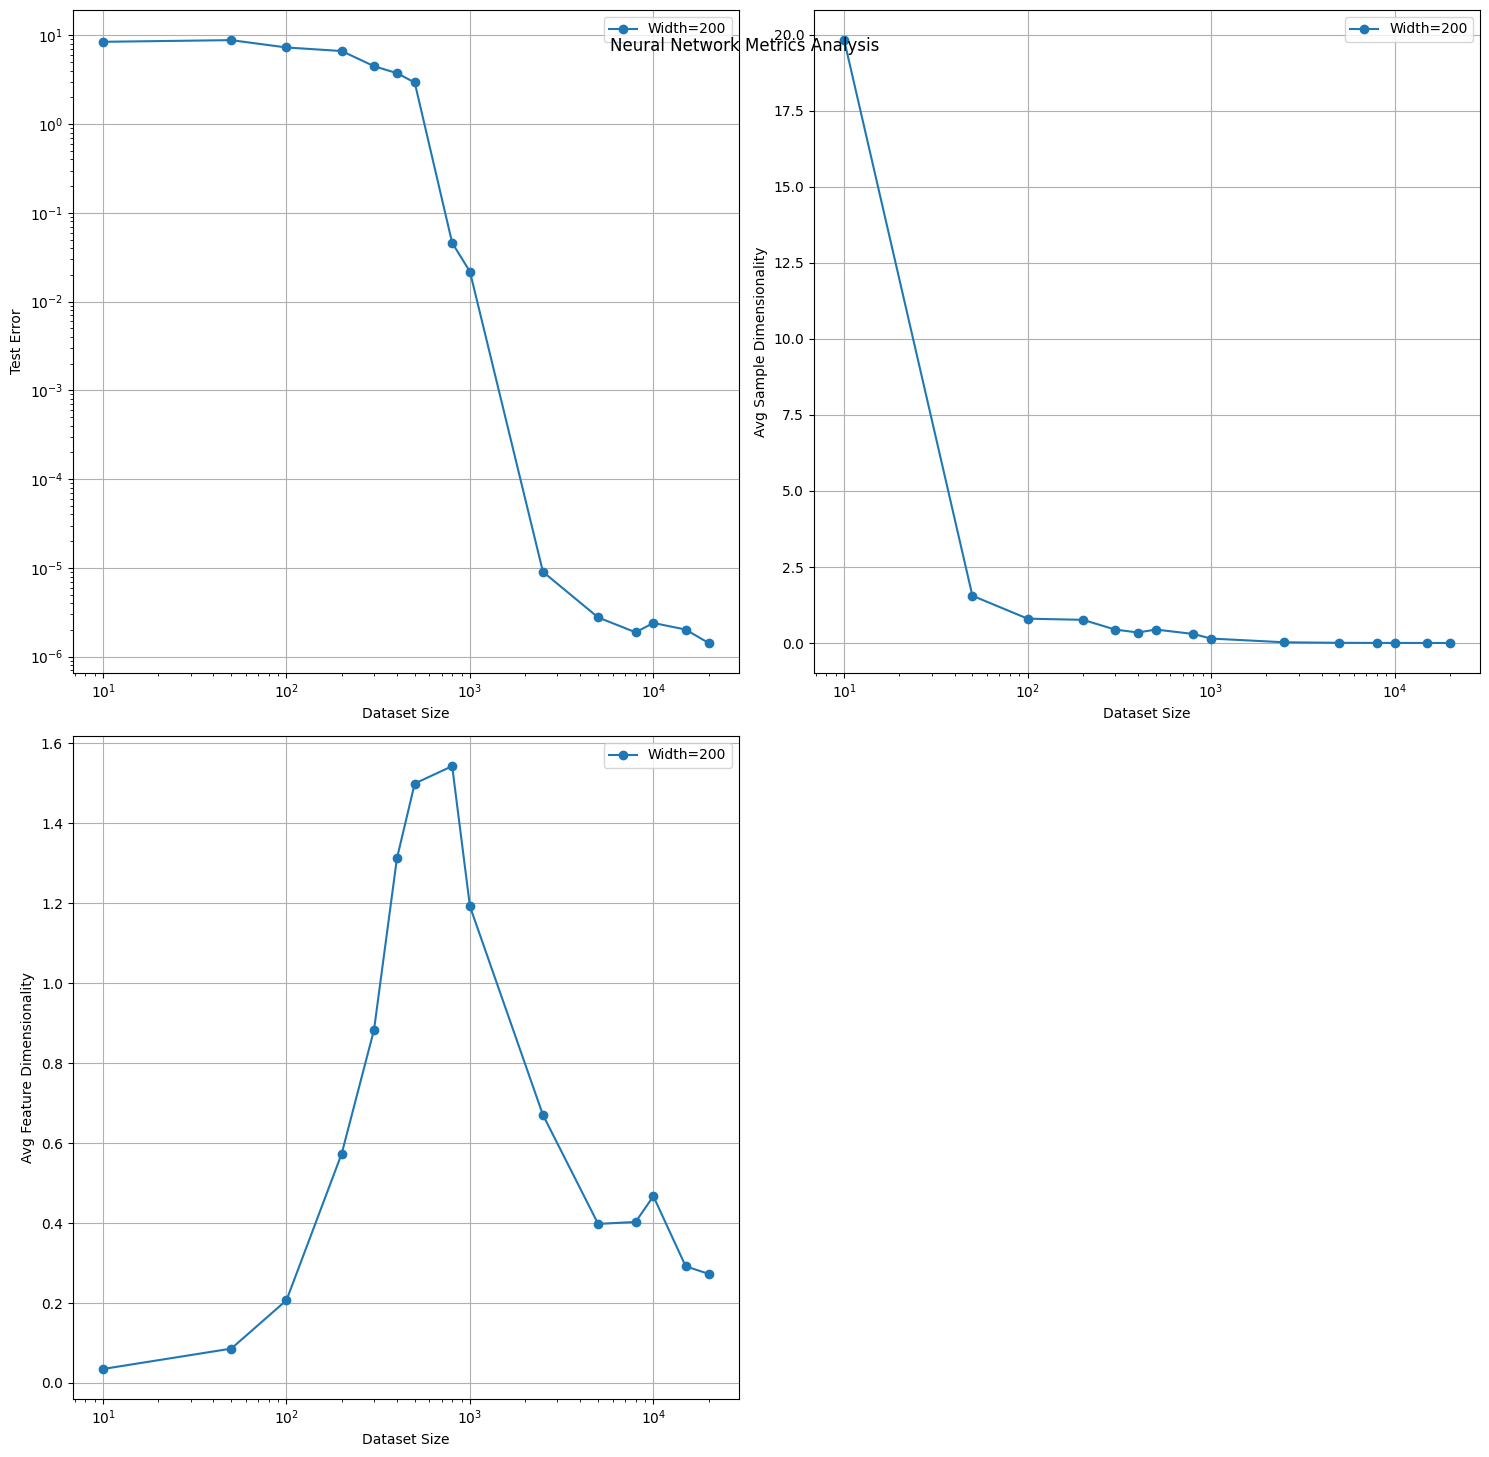

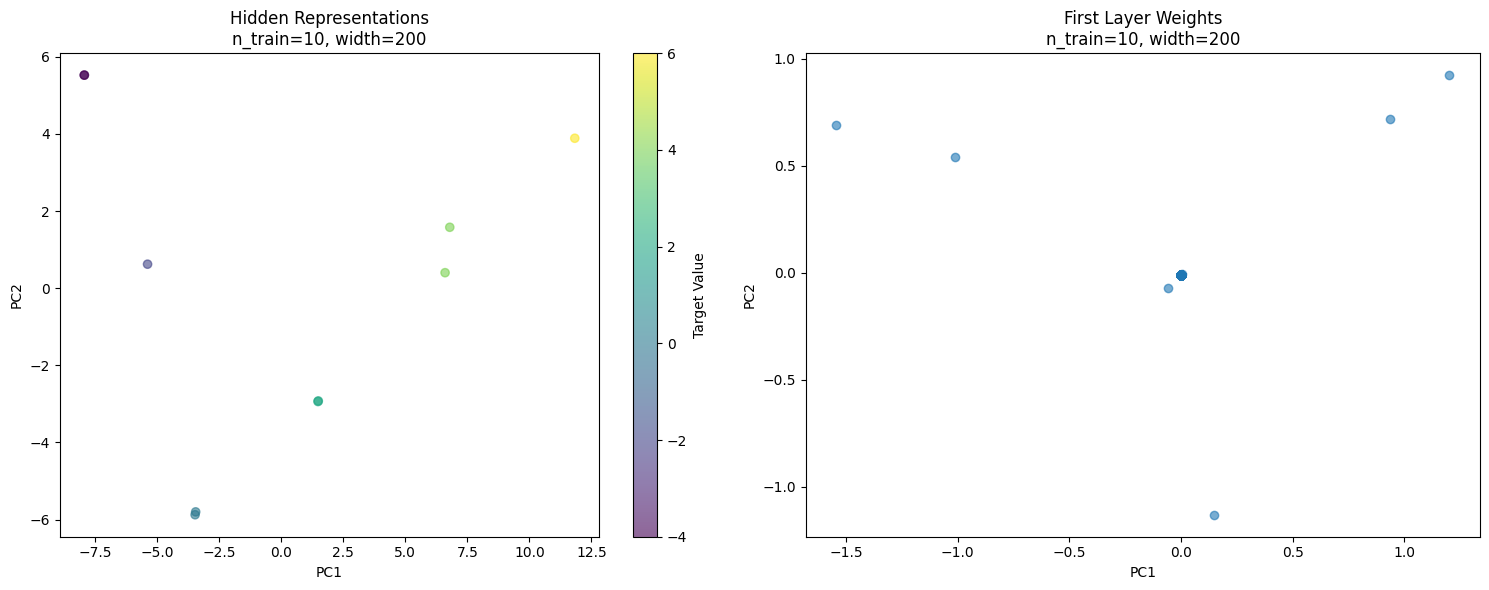

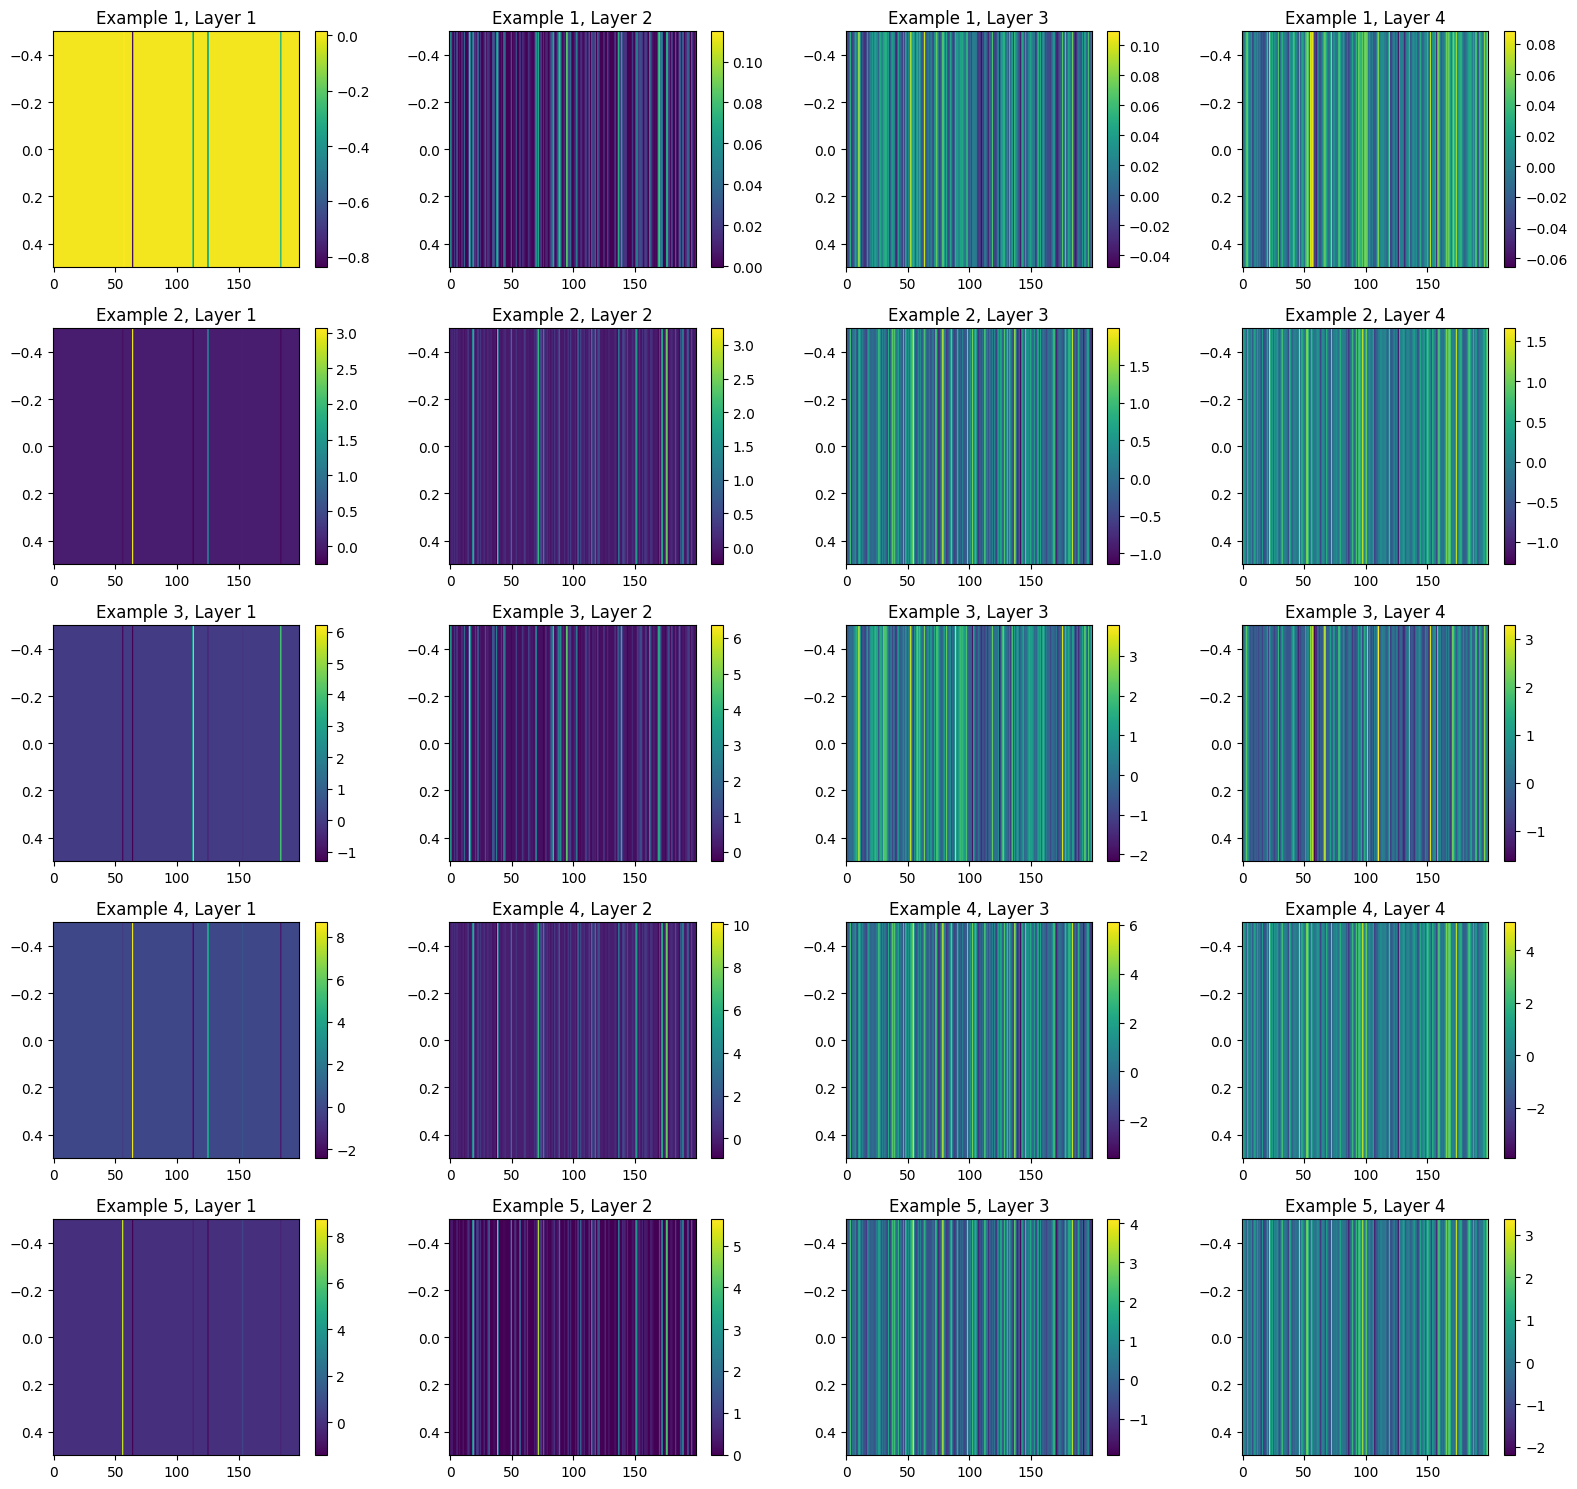

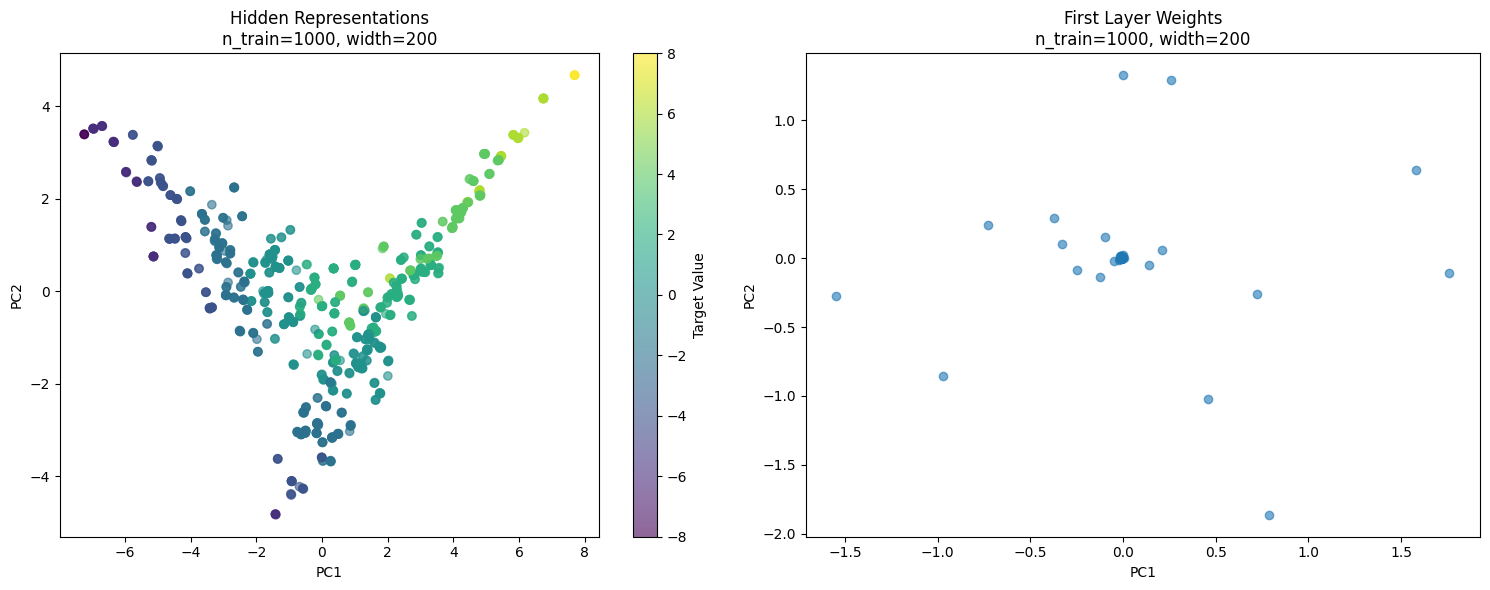

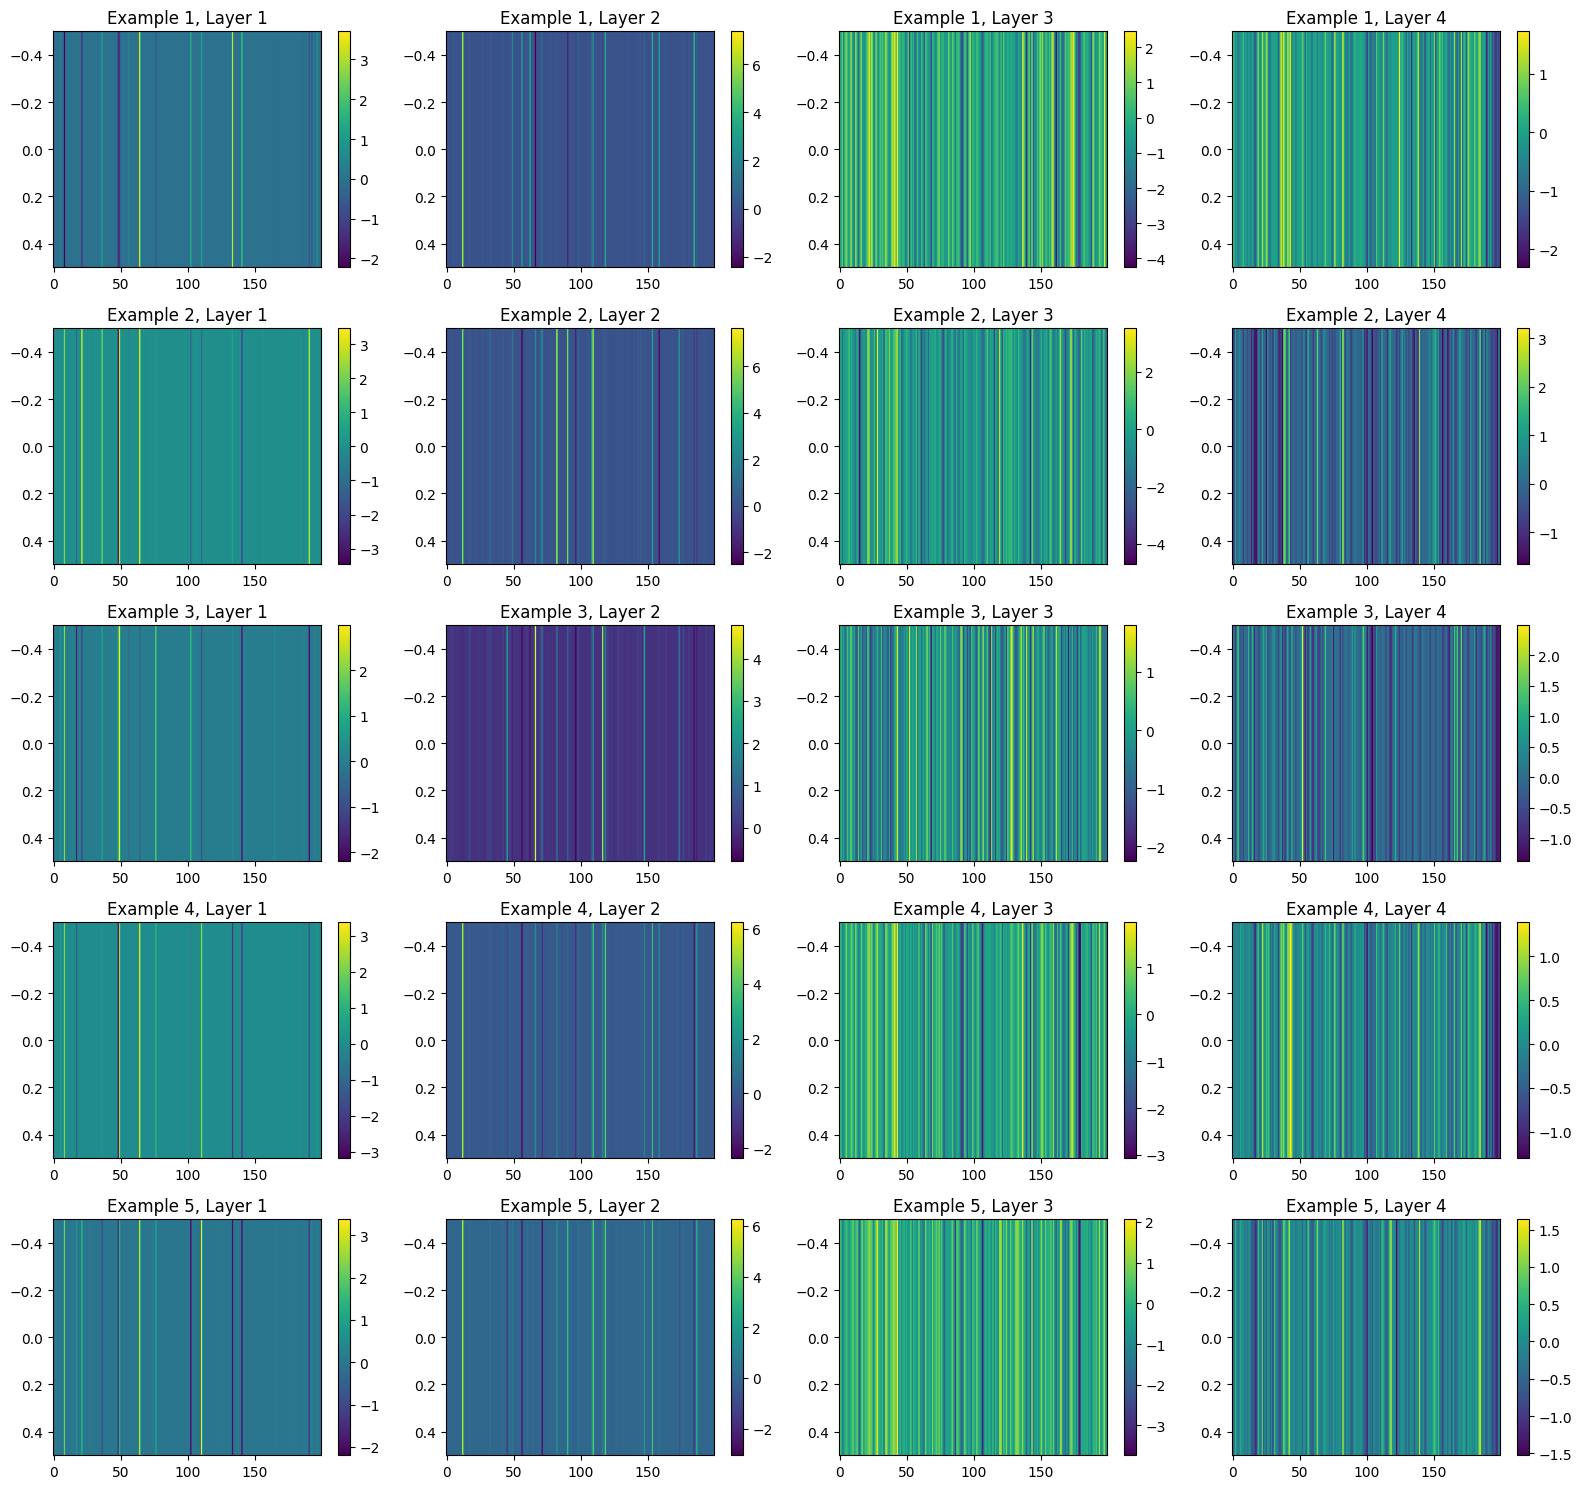

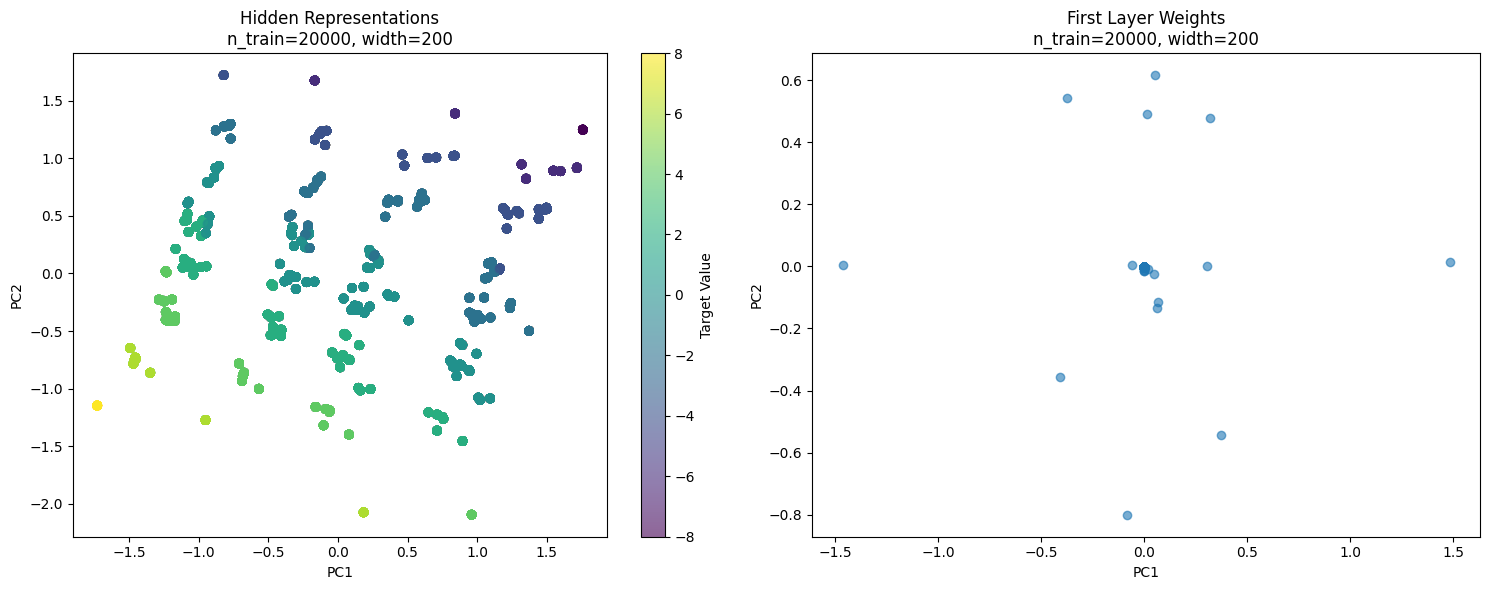

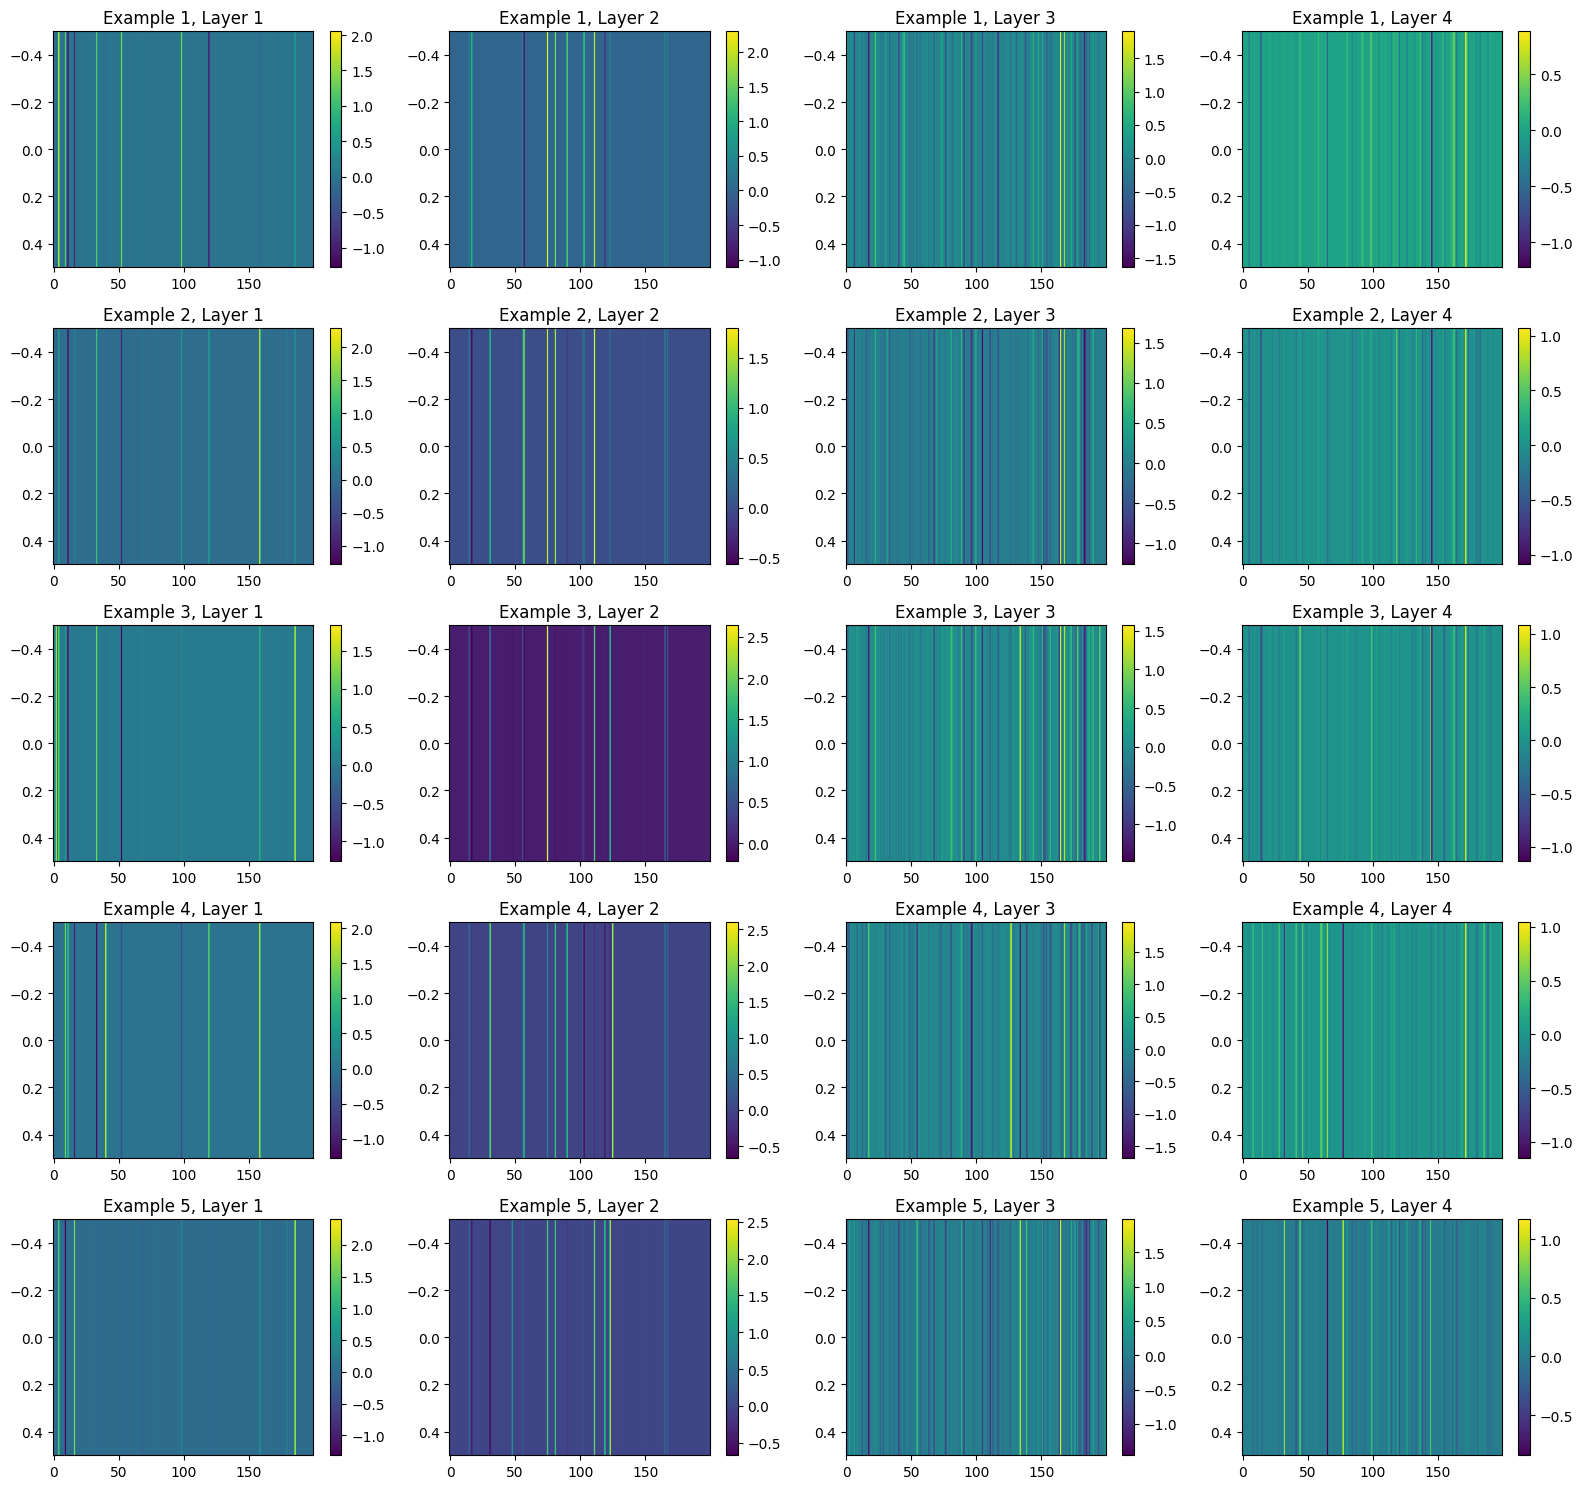

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from typing import Dict, List, Tuple

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load results and hyperparameters from experiment"""
    # Load results
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
        
    # Load hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
        
    return results, hyperparams

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            layers.extend([
                linear,
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        # Final layer
        final_layer = torch.nn.Linear(prev_dim, 1)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def load_model_and_data(data_dir: str, results_dir: str, result: Dict) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load model and its training data with new saving format"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load training data
    train_data_path = os.path.join(results_dir, result['train_data_path'])
    train_data = torch.load(train_data_path, weights_only=True)
    X_train, y_train = train_data['X'].to(device), train_data['y'].to(device)
    
    # Initialize model with same architecture
    model = DeepNN(
        d=X_train.shape[1],
        hidden_size=result['hidden_size'],
        depth=result['depth'],
        mode=result['mode']
    ).to(device)
    
    # Load model state dict with weights_only=True
    model_path = os.path.join(results_dir, result['final_model_path'])
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    
    return model, X_train, y_train

def compute_dimensionality_metrics(model: torch.nn.Module, X: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """Compute feature and sample dimensionality metrics"""
    with torch.no_grad():
        # Get hidden representations (assuming last layer before output)
        hidden = None
        for layer in model.network[:-1]:  # Skip final layer
            if hidden is None:
                hidden = layer(X)
            else:
                hidden = layer(hidden)
        
        # Normalize hidden vectors
        norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized = hidden / (norms + 1e-8)
        
        # Compute sample dimensionality (Anthropic's D_{X_i} metric)
        numerator = torch.sum(hidden * hidden, dim=1)
        denominator = torch.sum((normalized @ normalized.T) ** 2, dim=1)
        sample_dims = numerator / (denominator + 1e-8)
        
        # Compute feature dimensionality 
        W = model.network[0].weight.data  # First layer weights
        feature_norms = torch.norm(W, dim=0)
        normalized_W = W / (feature_norms + 1e-8)
        feature_dims = torch.sum(W * W, dim=0) / torch.sum((normalized_W.T @ normalized_W) ** 2, dim=0)
        
        return sample_dims, feature_dims

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str):
    """Analyze metrics across different dataset sizes and hidden sizes"""
    metrics = {
        'hidden_size': [],
        'n_train': [],
        'test_error': [],
        'avg_sample_dim': [],
        'std_sample_dim': [],
        'avg_feature_dim': [],
        'std_feature_dim': []
    }
    
    for result in results:
        print(f"Processing result: n_train={result['n_train']}, hidden_size={result['hidden_size']}")
        
        # Load model and data
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result)
        
        # Compute dimensionality metrics
        sample_dims, feature_dims = compute_dimensionality_metrics(model, X_train)
        
        # Store metrics
        metrics['hidden_size'].append(result['hidden_size'])
        metrics['n_train'].append(result['n_train'])
        metrics['test_error'].append(result['test_error'])
        metrics['avg_sample_dim'].append(float(torch.mean(sample_dims)))
        metrics['std_sample_dim'].append(float(torch.std(sample_dims)))
        metrics['avg_feature_dim'].append(float(torch.mean(feature_dims)))
        metrics['std_feature_dim'].append(float(torch.std(feature_dims)))
    
    return metrics

def visualize_features(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor, title: str = ""):
    """Visualize hidden representations and features using dimensionality reduction"""
    with torch.no_grad():
        # Get hidden representations
        hidden = None
        for layer in model.network[:-1]:
            if hidden is None:
                hidden = layer(X)
            else:
                hidden = layer(hidden)
        hidden = hidden.detach().cpu().numpy()
        
        # Get first layer weights
        W = model.network[0].weight.data.cpu().numpy()
        
        # Apply PCA to hidden representations and weights
        pca = PCA(n_components=2)
        hidden_2d = pca.fit_transform(hidden)
        W_2d = pca.fit_transform(W)
        
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot hidden representations
        scatter = ax1.scatter(hidden_2d[:, 0], hidden_2d[:, 1], c=y.cpu().numpy(), 
                            cmap='viridis', alpha=0.6)
        ax1.set_title(f'Hidden Representations\n{title}')
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        plt.colorbar(scatter, ax=ax1, label='Target Value')
        
        # Plot first layer weights
        ax2.scatter(W_2d[:, 0], W_2d[:, 1], alpha=0.6)
        ax2.set_title(f'First Layer Weights\n{title}')
        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2')
        
        plt.tight_layout()
        return fig

def plot_activation_patterns(model: torch.nn.Module, X: torch.Tensor, n_examples: int = 5):
    """Plot activation patterns for a few examples"""
    with torch.no_grad():
        # Get activations for each layer
        activations = []
        x = X[:n_examples]
        current = x
        
        for layer in model.network[:-1]:  # Exclude final layer
            if isinstance(layer, torch.nn.Linear):
                current = layer(current)
                activations.append(current.detach().cpu().numpy())
            else:
                current = layer(current)
        
        # Create plot
        fig, axes = plt.subplots(n_examples, len(activations), 
                                figsize=(4*len(activations), 3*n_examples))
        if n_examples == 1:
            axes = axes.reshape(1, -1)
        
        # Plot activation patterns
        for i in range(n_examples):
            for j, act in enumerate(activations):
                im = axes[i,j].imshow(act[i].reshape(1, -1), aspect='auto', cmap='viridis')
                axes[i,j].set_title(f'Example {i+1}, Layer {j+1}')
                plt.colorbar(im, ax=axes[i,j])
        
        plt.tight_layout()
        return fig

def plot_metrics(metrics: Dict):
    """Create plots similar to Anthropic paper"""
    # Convert to numpy arrays and sort by n_train for each hidden_size
    data = []
    for h in sorted(set(metrics['hidden_size'])):
        indices = [i for i, hs in enumerate(metrics['hidden_size']) if hs == h]
        data.append({
            'hidden_size': h,
            'n_train': np.array([metrics['n_train'][i] for i in indices]),
            'test_error': np.array([metrics['test_error'][i] for i in indices]),
            'avg_sample_dim': np.array([metrics['avg_sample_dim'][i] for i in indices]),
            'avg_feature_dim': np.array([metrics['avg_feature_dim'][i] for i in indices])
        })
        
        # Sort by n_train
        sort_idx = np.argsort(data[-1]['n_train'])
        data[-1]['n_train'] = data[-1]['n_train'][sort_idx]
        data[-1]['test_error'] = data[-1]['test_error'][sort_idx]
        data[-1]['avg_sample_dim'] = data[-1]['avg_sample_dim'][sort_idx]
        data[-1]['avg_feature_dim'] = data[-1]['avg_feature_dim'][sort_idx]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Plot test error
    for d in data:
        axes[0,0].plot(d['n_train'], d['test_error'], 
                      'o-', label=f'Width={d["hidden_size"]}')
    axes[0,0].set_xscale('log')
    axes[0,0].set_yscale('log')
    axes[0,0].set_xlabel('Dataset Size')
    axes[0,0].set_ylabel('Test Error')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Plot average sample dimensionality
    for d in data:
        axes[0,1].plot(d['n_train'], d['avg_sample_dim'],
                      'o-', label=f'Width={d["hidden_size"]}')
    axes[0,1].set_xscale('log')
    axes[0,1].set_xlabel('Dataset Size')
    axes[0,1].set_ylabel('Avg Sample Dimensionality')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Plot average feature dimensionality
    for d in data:
        axes[1,0].plot(d['n_train'], d['avg_feature_dim'],
                      'o-', label=f'Width={d["hidden_size"]}')
    axes[1,0].set_xscale('log')
    axes[1,0].set_xlabel('Dataset Size')
    axes[1,0].set_ylabel('Avg Feature Dimensionality')
    axes[1,0].legend()
    axes[1,0].grid(True)
    
    # Add title
    axes[1,1].remove()  # Remove unused subplot
    fig.suptitle('Neural Network Metrics Analysis', y=0.95)
    
    plt.tight_layout()
    return fig

# Example usage:
def main():
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro"
    data_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro"
    timestamp = "20250101_171010"
    
    # Load data
    results, hyperparams = load_experiment_data(results_dir, timestamp)
    
    # Analyze metrics
    metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir)
    
    # Create metrics plots
    metrics_fig = plot_metrics(metrics)
    plt.show()
    
    # For a few selected configurations, visualize features
    interesting_configs = [
        {'n_train': min(hyperparams['n_train_sizes']), 'hidden_size': 200},  # Small dataset
        {'n_train': 1000, 'hidden_size': 200},  # Medium dataset
        {'n_train': max(hyperparams['n_train_sizes']), 'hidden_size': 200}   # Large dataset
    ]
    
    for config in interesting_configs:
        # Find matching result
        result = next((r for r in results 
                      if r['n_train'] == config['n_train'] 
                      and r['hidden_size'] == config['hidden_size']), None)
        
        if result:
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result)
            
            # Visualize features
            feature_fig = visualize_features(model, X_train, y_train, 
                                          f"n_train={config['n_train']}, width={config['hidden_size']}")
            plt.show()
            
            # Plot activation patterns
            activation_fig = plot_activation_patterns(model, X_train)
            plt.show()

if __name__ == "__main__":
    main()

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float]:
    """Compute Anthropic's dimensionality metrics
    Returns mean sample dimensionality and mean feature dimensionality"""
    with torch.no_grad():
        # Normalize hidden vectors
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        
        # Compute sample dimensionality
        hidden_dots = normalized_hidden @ normalized_hidden.T
        sample_dims = torch.sum(hidden * hidden, dim=1) / (torch.sum(hidden_dots * hidden_dots, dim=1) + 1e-8)
        
        # Normalize features (first layer weights)
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        
        # Compute feature dimensionality
        feature_dots = normalized_features.T @ normalized_features
        feature_dims = torch.sum(features * features, dim=0) / (torch.sum(feature_dots * feature_dots, dim=0) + 1e-8)
        
        return float(torch.mean(sample_dims)), float(torch.mean(feature_dims))

def compute_lesswrong_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float]:
    """Compute LessWrong's fractional dimensionality metrics using SVD"""
    with torch.no_grad():
        # Normalize hidden representations
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        
        # Compute SVD for hidden representations
        _, S_hidden, _ = torch.svd(normalized_hidden)
        hidden_dim = torch.sum(S_hidden) / (torch.max(S_hidden) * S_hidden.shape[0] + 1e-8)
        
        # Normalize features
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        
        # Compute SVD for features
        _, S_features, _ = torch.svd(normalized_features)
        feature_dim = torch.sum(S_features) / (torch.max(S_features) * S_features.shape[0] + 1e-8)
        
        return float(hidden_dim), float(feature_dim)

def analyze_dimensionality(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute both dimensionality metrics for the given model and data"""
    with torch.no_grad():
        # Get hidden representations (before last layer)
        hidden = None
        for layer in model.network[:-1]:
            if hidden is None:
                hidden = layer(X)
            else:
                hidden = layer(hidden)
        
        # Get first layer weights
        features = model.network[0].weight.data
        
        # Compute both metrics
        anth_sample_dim, anth_feature_dim = compute_anthropic_dimensionality(hidden, features)
        lw_hidden_dim, lw_feature_dim = compute_lesswrong_dimensionality(hidden, features)
        
        return {
            'anthropic': {
                'sample_dim': anth_sample_dim,
                'feature_dim': anth_feature_dim
            },
            'lesswrong': {
                'hidden_dim': lw_hidden_dim,
                'feature_dim': lw_feature_dim
            }
        }

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str):
    """Analyze metrics across different dataset sizes"""
    sorted_results = sorted(results, key=lambda x: x['n_train'])
    
    metrics = {
        'n_train': [],
        'anthropic_sample_dim': [],
        'anthropic_feature_dim': [],
        'lesswrong_hidden_dim': [],
        'lesswrong_feature_dim': []
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, hidden_size={result['hidden_size']}")
        
        # Load model and data
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result)
        
        # Compute dimensionality metrics
        dims = analyze_dimensionality(model, X_train)
        
        # Store metrics
        metrics['n_train'].append(result['n_train'])
        metrics['anthropic_sample_dim'].append(dims['anthropic']['sample_dim'])
        metrics['anthropic_feature_dim'].append(dims['anthropic']['feature_dim'])
        metrics['lesswrong_hidden_dim'].append(dims['lesswrong']['hidden_dim'])
        metrics['lesswrong_feature_dim'].append(dims['lesswrong']['feature_dim'])
    
    return metrics

def plot_comparative_analysis(metrics: Dict):
    """Create comparative plots for both dimensionality metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Plot Anthropic metrics
    axes[0, 0].plot(metrics['n_train'], metrics['anthropic_sample_dim'], 'b-')
    axes[0, 0].set_xlabel('Dataset Size')
    axes[0, 0].set_ylabel('Sample Dimensionality')
    axes[0, 0].set_xscale('log')
    axes[0, 0].grid(True)
    axes[0, 0].set_title('Anthropic Sample Dimensionality')

    axes[0, 1].plot(metrics['n_train'], metrics['anthropic_feature_dim'], 'r-')
    axes[0, 1].set_xlabel('Dataset Size')
    axes[0, 1].set_ylabel('Feature Dimensionality')
    axes[0, 1].set_xscale('log')
    axes[0, 1].grid(True)
    axes[0, 1].set_title('Anthropic Feature Dimensionality')

    # Plot LessWrong metrics
    axes[1, 0].plot(metrics['n_train'], metrics['lesswrong_hidden_dim'], 'g-')
    axes[1, 0].set_xlabel('Dataset Size')
    axes[1, 0].set_ylabel('Hidden Dimensionality')
    axes[1, 0].set_xscale('log')
    axes[1, 0].grid(True)
    axes[1, 0].set_title('LessWrong Hidden Dimensionality')

    axes[1, 1].plot(metrics['n_train'], metrics['lesswrong_feature_dim'], 'm-')
    axes[1, 1].set_xlabel('Dataset Size')
    axes[1, 1].set_ylabel('Feature Dimensionality')
    axes[1, 1].set_xscale('log')
    axes[1, 1].grid(True)
    axes[1, 1].set_title('LessWrong Feature Dimensionality')

    plt.tight_layout()
    return fig

def main():
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro"
    data_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro"
    timestamp = "20250101_171010"
    
    # Load data
    results, hyperparams = load_experiment_data(results_dir, timestamp)
    
    # Analyze metrics
    metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir)
    
    # Create comparative plots
    fig = plot_comparative_analysis(metrics)
    plt.show()

if __name__ == "__main__":
    main()

Processing result: n_train=10, hidden_size=200


TypeError: load_model_and_data() missing 1 required positional argument: 'timestamp'

Processing result: n_train=10, hidden_size=200
Processing result: n_train=50, hidden_size=200
Processing result: n_train=100, hidden_size=200
Processing result: n_train=200, hidden_size=200
Processing result: n_train=300, hidden_size=200
Processing result: n_train=400, hidden_size=200
Processing result: n_train=500, hidden_size=200
Processing result: n_train=800, hidden_size=200
Processing result: n_train=1000, hidden_size=200
Processing result: n_train=2500, hidden_size=200
Processing result: n_train=5000, hidden_size=200
Processing result: n_train=8000, hidden_size=200
Processing result: n_train=10000, hidden_size=200
Processing result: n_train=15000, hidden_size=200
Processing result: n_train=20000, hidden_size=200


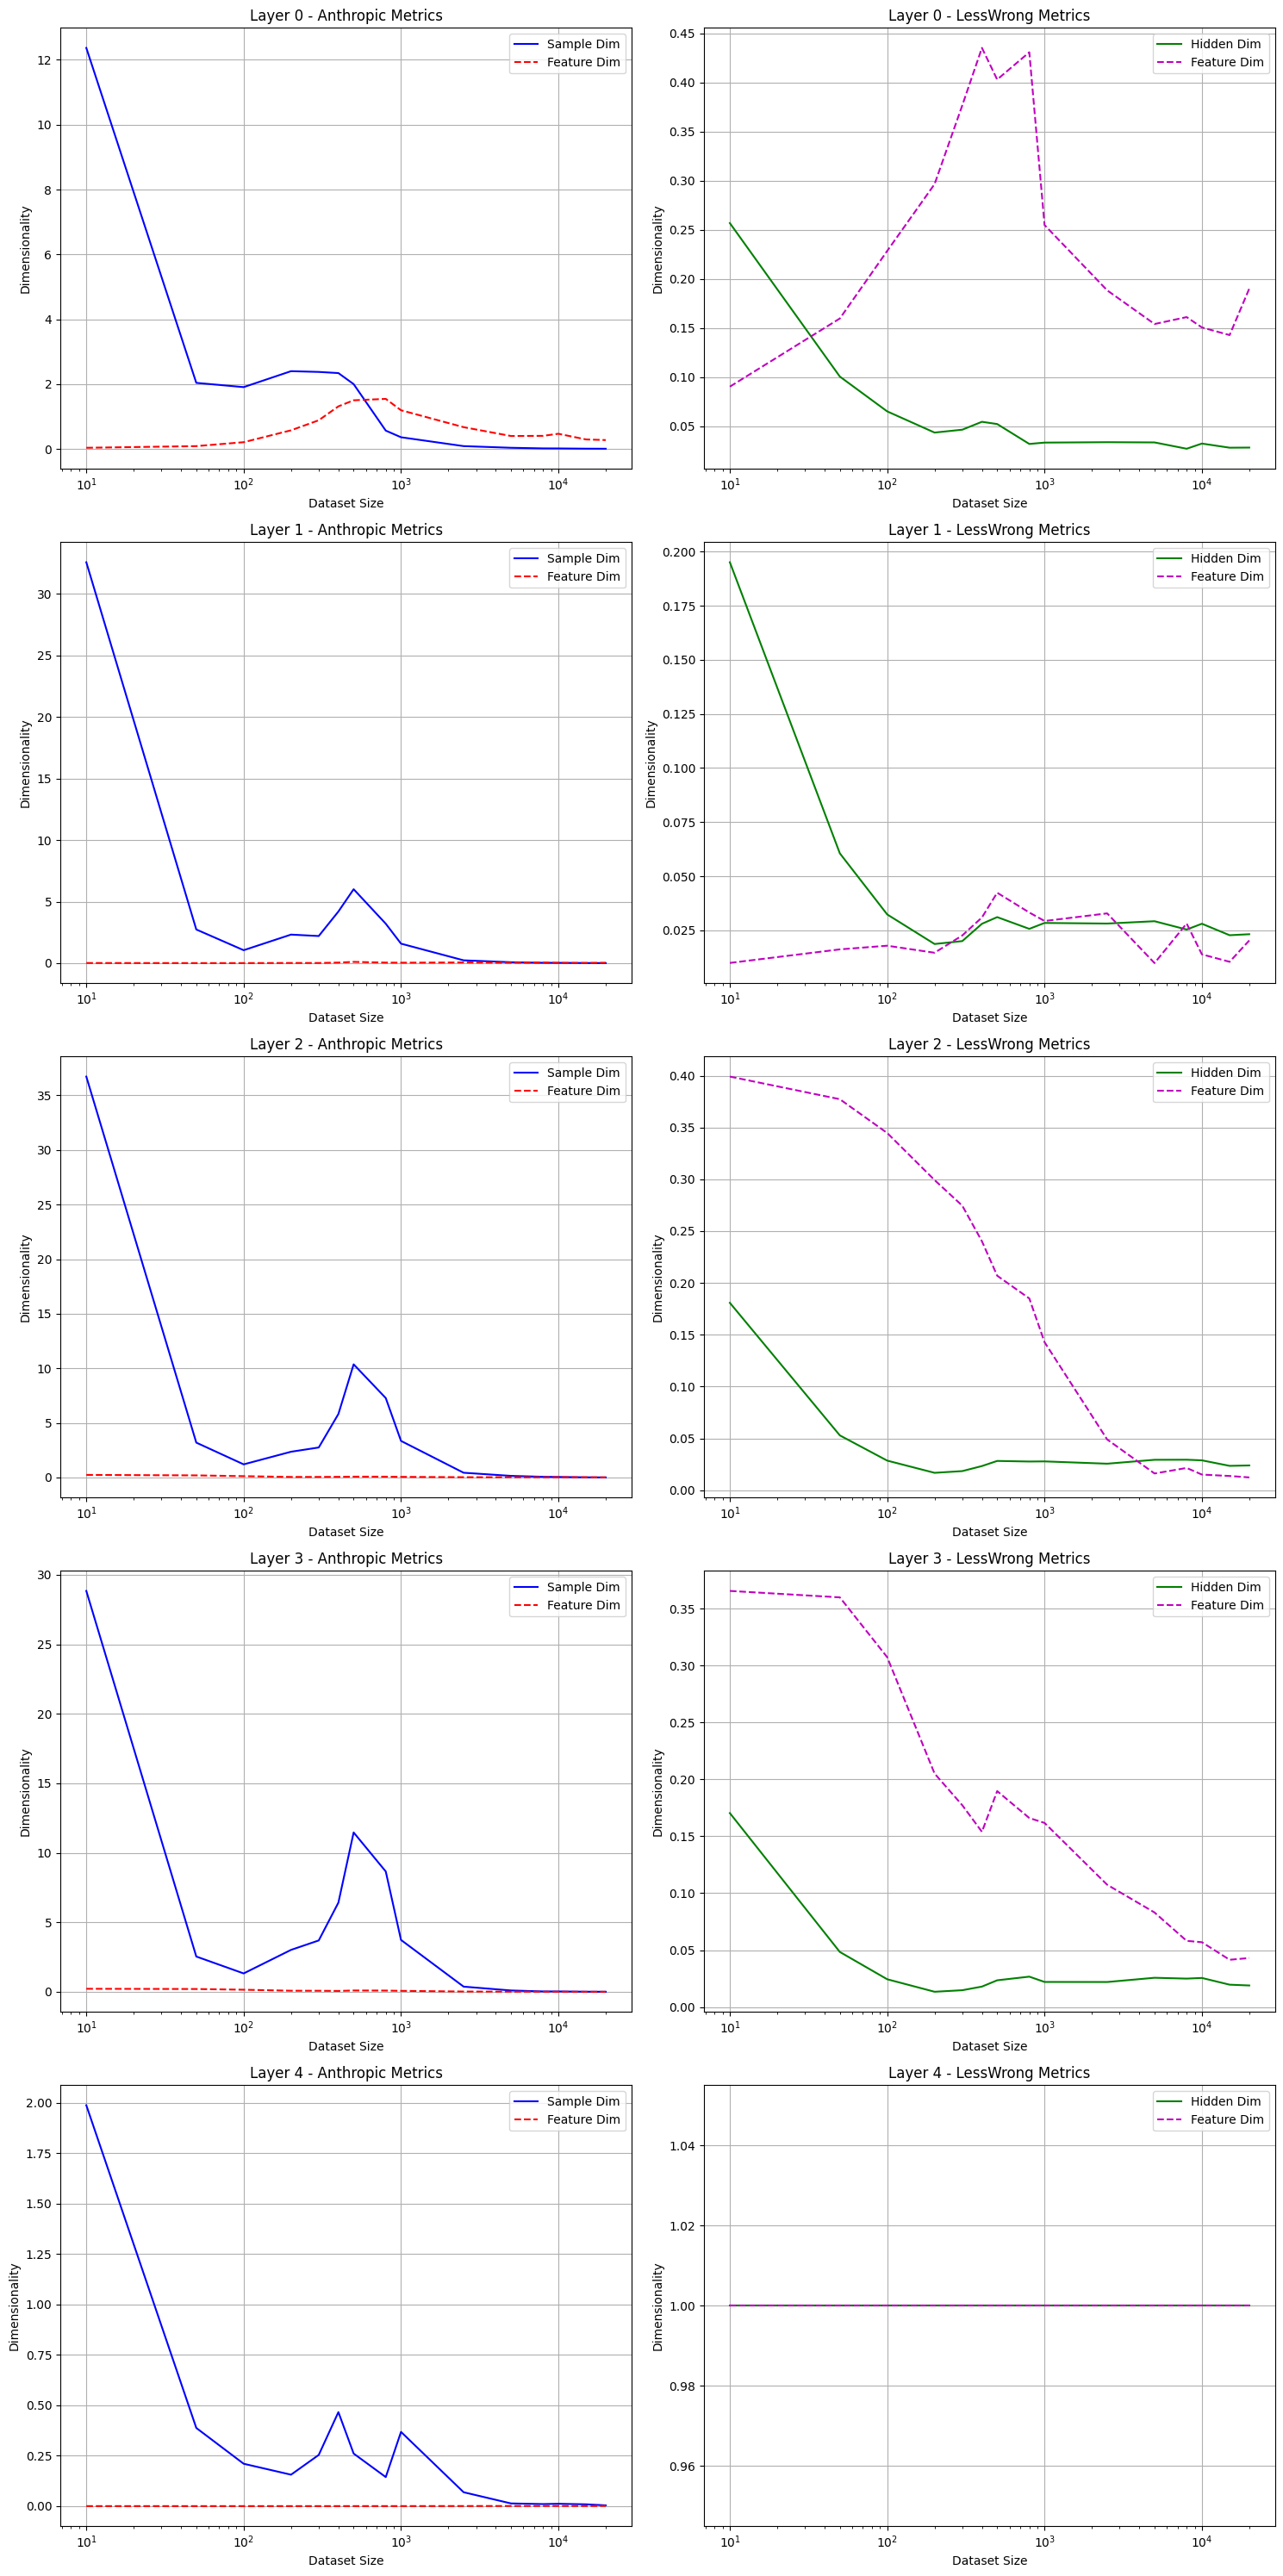

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float]:
    """Compute Anthropic's dimensionality metrics
    Returns mean sample dimensionality and mean feature dimensionality"""
    with torch.no_grad():
        # Normalize hidden vectors
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        
        # Compute sample dimensionality
        hidden_dots = normalized_hidden @ normalized_hidden.T
        sample_dims = torch.sum(hidden * hidden, dim=1) / (torch.sum(hidden_dots * hidden_dots, dim=1) + 1e-8)
        
        # Normalize features
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        
        # Compute feature dimensionality
        feature_dots = normalized_features.T @ normalized_features
        feature_dims = torch.sum(features * features, dim=0) / (torch.sum(feature_dots * feature_dots, dim=0) + 1e-8)
        
        return float(torch.mean(sample_dims)), float(torch.mean(feature_dims))

def compute_lesswrong_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float]:
    """Compute LessWrong's fractional dimensionality metrics using SVD"""
    with torch.no_grad():
        # Normalize hidden representations
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        
        # Compute SVD for hidden representations
        _, S_hidden, _ = torch.svd(normalized_hidden)
        hidden_dim = torch.sum(S_hidden) / (torch.max(S_hidden) * S_hidden.shape[0] + 1e-8)
        
        # Normalize features
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        
        # Compute SVD for features
        _, S_features, _ = torch.svd(normalized_features)
        feature_dim = torch.sum(S_features) / (torch.max(S_features) * S_features.shape[0] + 1e-8)
        
        return float(hidden_dim), float(feature_dim)

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer of the model"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            # Get layer weights
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue  # Skip layers without weights (e.g., activation functions)
            
            # Forward pass through this layer
            current_activation = layer(current_activation)
            
            # Compute both metrics for this layer
            anth_sample_dim, anth_feature_dim = compute_anthropic_dimensionality(
                current_activation, features)
            lw_hidden_dim, lw_feature_dim = compute_lesswrong_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': anth_sample_dim,
                    'feature_dim': anth_feature_dim
                },
                'lesswrong': {
                    'hidden_dim': lw_hidden_dim,
                    'feature_dim': lw_feature_dim
                }
            })
    
    return layer_metrics

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str):
    """Analyze metrics across different dataset sizes for all layers"""
    sorted_results = sorted(results, key=lambda x: x['n_train'])
    
    # Initialize metrics dictionary with empty lists for each layer
    metrics = {
        'n_train': [],
        'layers': []  # Will contain metrics for each layer
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, hidden_size={result['hidden_size']}")
        
        # Load model and data
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result)
        
        # Compute dimensionality metrics for all layers
        layer_metrics = analyze_dimensionality_by_layer(model, X_train)
        
        # Store metrics
        metrics['n_train'].append(result['n_train'])
        metrics['layers'].append(layer_metrics)
    
    return metrics

def plot_comparative_analysis_by_layer(metrics: Dict):
    """Create comparative plots for both dimensionality metrics across all layers"""
    n_layers = len(metrics['layers'][0])
    fig, axes = plt.subplots(n_layers, 2, figsize=(15, 6*n_layers))
    
    for layer_idx in range(n_layers):
        # Extract metrics for this layer
        layer_anthropic_sample = [layer_metrics[layer_idx]['anthropic']['sample_dim'] 
                                for layer_metrics in metrics['layers']]
        layer_anthropic_feature = [layer_metrics[layer_idx]['anthropic']['feature_dim'] 
                                 for layer_metrics in metrics['layers']]
        layer_lesswrong_hidden = [layer_metrics[layer_idx]['lesswrong']['hidden_dim'] 
                                for layer_metrics in metrics['layers']]
        layer_lesswrong_feature = [layer_metrics[layer_idx]['lesswrong']['feature_dim'] 
                                 for layer_metrics in metrics['layers']]
        
        # Plot Anthropic metrics for this layer
        axes[layer_idx, 0].plot(metrics['n_train'], layer_anthropic_sample, 'b-', 
                              label='Sample Dim')
        axes[layer_idx, 0].plot(metrics['n_train'], layer_anthropic_feature, 'r--', 
                              label='Feature Dim')
        axes[layer_idx, 0].set_xlabel('Dataset Size')
        axes[layer_idx, 0].set_ylabel('Dimensionality')
        axes[layer_idx, 0].set_xscale('log')
        axes[layer_idx, 0].grid(True)
        axes[layer_idx, 0].set_title(f'Layer {layer_idx} - Anthropic Metrics')
        axes[layer_idx, 0].legend()

        # Plot LessWrong metrics for this layer
        axes[layer_idx, 1].plot(metrics['n_train'], layer_lesswrong_hidden, 'g-', 
                              label='Hidden Dim')
        axes[layer_idx, 1].plot(metrics['n_train'], layer_lesswrong_feature, 'm--', 
                              label='Feature Dim')
        axes[layer_idx, 1].set_xlabel('Dataset Size')
        axes[layer_idx, 1].set_ylabel('Dimensionality')
        axes[layer_idx, 1].set_xscale('log')
        axes[layer_idx, 1].grid(True)
        axes[layer_idx, 1].set_title(f'Layer {layer_idx} - LessWrong Metrics')
        axes[layer_idx, 1].legend()

    plt.tight_layout()
    return fig

def main():
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro"
    data_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro"
    timestamp = "20250101_171010"
    
    # Load data
    results, hyperparams = load_experiment_data(results_dir, timestamp)
    
    # Analyze metrics for all layers
    metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir)
    
    # Create comparative plots
    fig = plot_comparative_analysis_by_layer(metrics)
    plt.show()

if __name__ == "__main__":
    main()

Processing result: n_train=10, hidden_size=400, lr=0.001


/tmp/ipykernel_3767838/3167391629.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_3767838/3167391629.py:61:

Processing result: n_train=50, hidden_size=400, lr=0.001
Processing result: n_train=100, hidden_size=400, lr=0.001
Processing result: n_train=200, hidden_size=400, lr=0.001
Processing result: n_train=300, hidden_size=400, lr=0.001
Processing result: n_train=400, hidden_size=400, lr=0.001
Processing result: n_train=500, hidden_size=400, lr=0.001
Processing result: n_train=800, hidden_size=400, lr=0.001
Processing result: n_train=1000, hidden_size=400, lr=0.001
Processing result: n_train=2500, hidden_size=400, lr=0.001
Processing result: n_train=5000, hidden_size=400, lr=0.001
Processing result: n_train=8000, hidden_size=400, lr=0.001
Processing result: n_train=10000, hidden_size=400, lr=0.001
Processing result: n_train=15000, hidden_size=400, lr=0.001
Processing result: n_train=20000, hidden_size=400, lr=0.001
Processing result: n_train=10, hidden_size=50, lr=0.001
Processing result: n_train=50, hidden_size=50, lr=0.001
Processing result: n_train=100, hidden_size=50, lr=0.001
Processing

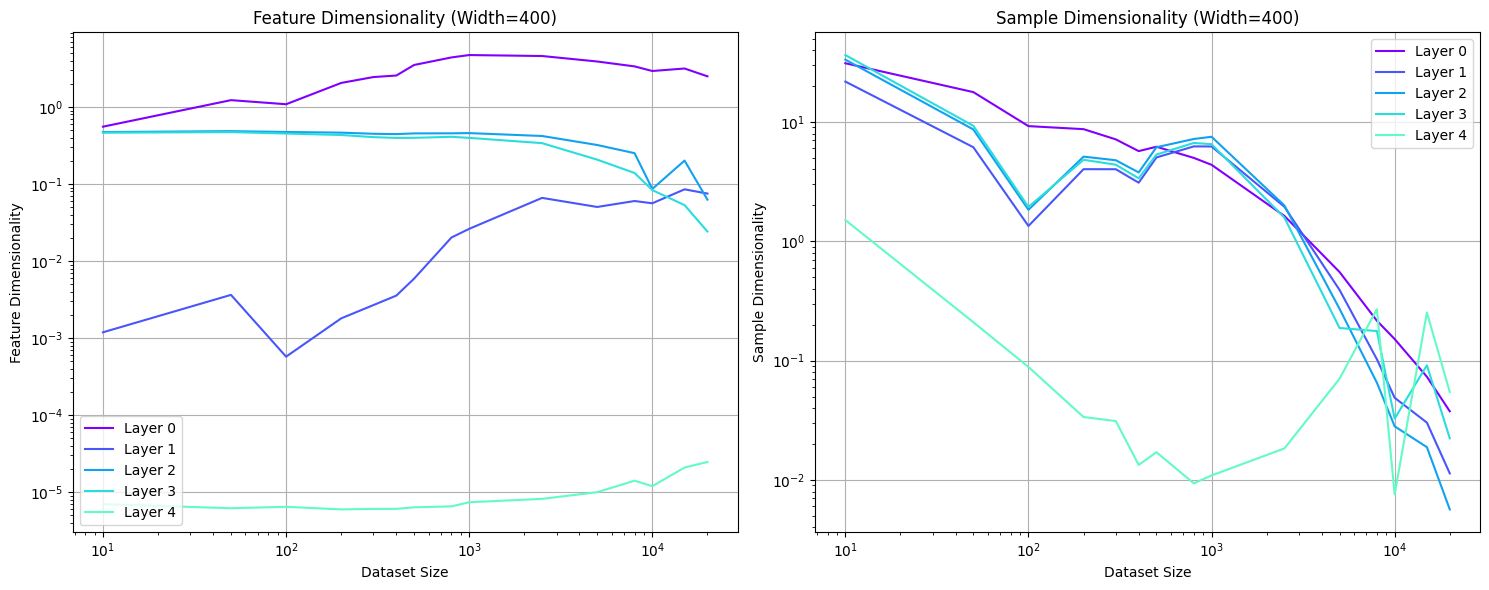

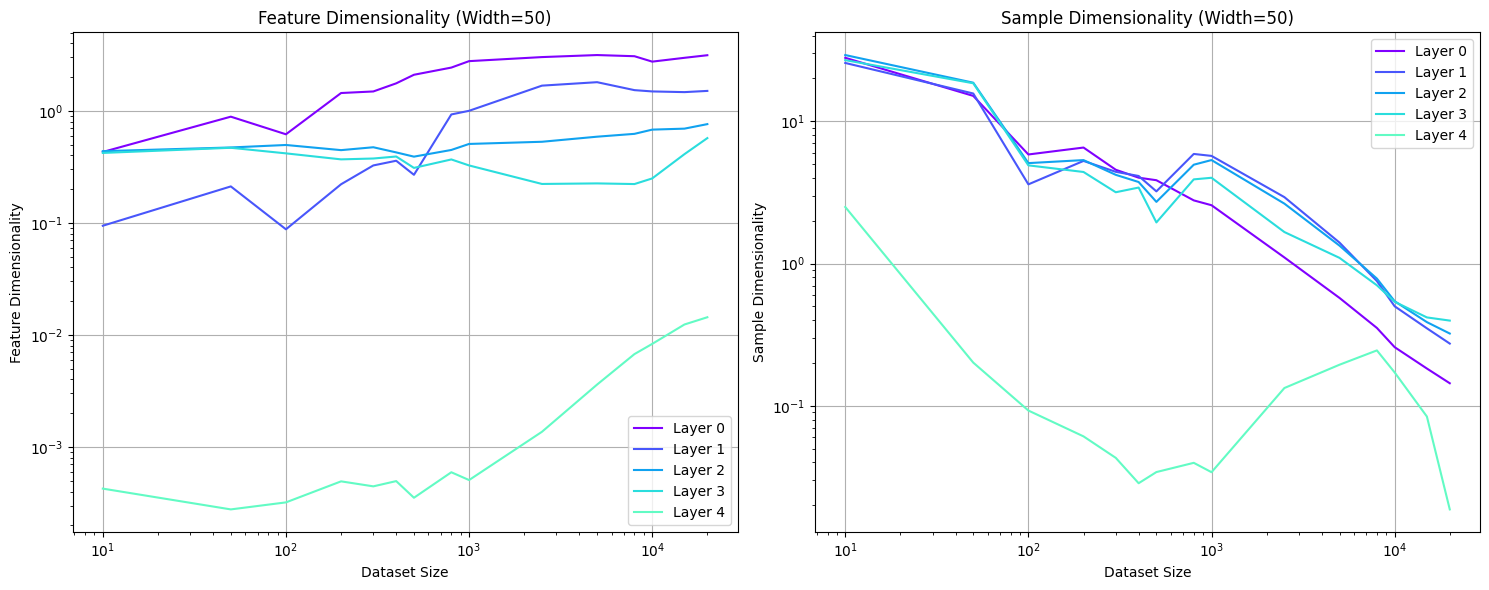

In [13]:
import torch
import os
import json
from typing import Tuple, Dict, List

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    # Load hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    # Load final results
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data
    
    Args:
        data_dir: Directory containing the dataset files
        results_dir: Directory containing the model files
        result: Dictionary containing the model configuration
        timestamp: Timestamp string for loading correct model version
        
    Returns:
        model: Loaded PyTorch model
        X_train: Training features
        y_train: Training labels
    """
    # Get input dimension from hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    # Extract model parameters
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    
    # Construct model prefix
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    # Load final model
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode)
    model.load_state_dict(torch.load(model_path))
    
    # Load training data
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    # Extract X and y from the saved dictionary format
    X_train = train_data['X']
    y_train = train_data['y']
    
    # Move to the same device as the model
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard'):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            
            layers.extend([
                linear,
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        # Final layer
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, timestamp: str, target_lr=None):
    """Analyze metrics across different dataset sizes and model widths
    
    Args:
        results: List of result dictionaries
        hyperparams: Dictionary of hyperparameters
        data_dir: Directory containing data
        results_dir: Directory containing results
        timestamp: Experiment timestamp
        target_lr: Optional specific learning rate to analyze (e.g., 0.001 or 0.05)
    """
    # Get input dimension from hyperparameters
    input_dim = hyperparams['d']
    
    # First filter by learning rate if specified
    if target_lr is not None:
        results = [r for r in results if r['learning_rate'] == target_lr]
    
    # Group results by hidden_size
    width_groups = {}
    for result in results:
        hidden_size = result['hidden_size']
        if hidden_size not in width_groups:
            width_groups[hidden_size] = []
        width_groups[hidden_size].append(result)
    
    all_metrics = {}
    for hidden_size, group_results in width_groups.items():
        sorted_results = sorted(group_results, key=lambda x: x['n_train'])
        
        metrics = {
            'n_train': [],
            'layers': []
        }
        
        for result in sorted_results:
            print(f"Processing result: n_train={result['n_train']}, hidden_size={hidden_size}, lr={result['learning_rate']}")
            
            # Load model and data with timestamp
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
            
            # Compute dimensionality metrics for all layers
            layer_metrics = analyze_dimensionality_by_layer(model, X_train)
            
            # Store metrics
            metrics['n_train'].append(result['n_train'])
            metrics['layers'].append(layer_metrics)
        
        all_metrics[hidden_size] = metrics
    
    return all_metrics

def plot_dimensionality_analysis(all_metrics: Dict, metric_type='anthropic'):
    """Create separate plots for each model width, showing feature and sample dimensionality
    
    Args:
        all_metrics: Dictionary of metrics for different model widths
        metric_type: Which metric set to plot ('anthropic' or 'lesswrong')
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    colors = plt.cm.rainbow(np.linspace(0, 1, 10))  # Color palette for different layers
    
    for hidden_size, metrics in all_metrics.items():
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Get number of layers
        n_layers = len(metrics['layers'][0])
        
        # Plot feature dimensionality
        for layer_idx in range(n_layers):
            # Access the nested metrics structure correctly
            layer_feature_dims = [layer_metrics[layer_idx][metric_type]['feature_dim'] 
                                for layer_metrics in metrics['layers']]
            
            ax1.plot(metrics['n_train'], layer_feature_dims, '-', 
                    color=colors[layer_idx], label=f'Layer {layer_idx}')
        
        ax1.set_xlabel('Dataset Size')
        ax1.set_ylabel('Feature Dimensionality')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.grid(True)
        ax1.set_title(f'Feature Dimensionality (Width={hidden_size})')
        ax1.legend()
        
        # Plot sample/hidden dimensionality
        for layer_idx in range(n_layers):
            # Use correct key based on metric type
            dim_key = 'hidden_dim' if metric_type == 'lesswrong' else 'sample_dim'
            layer_sample_dims = [layer_metrics[layer_idx][metric_type][dim_key] 
                               for layer_metrics in metrics['layers']]
            
            ax2.plot(metrics['n_train'], layer_sample_dims, '-', 
                    color=colors[layer_idx], label=f'Layer {layer_idx}')
        
        ax2.set_xlabel('Dataset Size')
        ax2.set_ylabel('Hidden Dimensionality' if metric_type == 'lesswrong' else 'Sample Dimensionality')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.grid(True)
        ax2.set_title(f'{"Hidden" if metric_type == "lesswrong" else "Sample"} Dimensionality (Width={hidden_size})')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer of the model"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            # Get layer weights
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue  # Skip layers without weights (e.g., activation functions)
            
            # Forward pass through this layer
            current_activation = layer(current_activation)
            
            # Compute both metrics for this layer
            anth_sample_dim, anth_feature_dim = compute_anthropic_dimensionality(
                current_activation, features)
            lw_hidden_dim, lw_feature_dim = compute_lesswrong_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': anth_sample_dim,
                    'feature_dim': anth_feature_dim
                },
                'lesswrong': {
                    'hidden_dim': lw_hidden_dim,
                    'feature_dim': lw_feature_dim
                }
            })
    
    return layer_metrics

def main():
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0102_shuffled_mup_true"
    data_dir = results_dir
    timestamp = "20250103_052807"
    
    # Load data
    results, hyperparams = load_experiment_data(results_dir, timestamp)
    
    # Analyze metrics for all layers and model widths, for learning rate 0.001
    all_metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir, timestamp, target_lr=0.001)
    
    # Create plots
    plot_dimensionality_analysis(all_metrics, metric_type='anthropic')

if __name__ == "__main__":
    main()

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import os

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float]:
    """Compute Anthropic's dimensionality metrics
    Returns mean sample dimensionality and mean feature dimensionality"""
    with torch.no_grad():
        # Normalize hidden vectors
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        
        # Compute sample dimensionality
        hidden_dots = normalized_hidden @ normalized_hidden.T
        sample_dims = torch.sum(hidden * hidden, dim=1) / (torch.sum(hidden_dots * hidden_dots, dim=1) + 1e-8)
        
        # Normalize features
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        
        # Compute feature dimensionality
        feature_dots = normalized_features.T @ normalized_features
        feature_dims = torch.sum(features * features, dim=0) / (torch.sum(feature_dots * feature_dots, dim=0) + 1e-8)
        
        return float(torch.mean(sample_dims)), float(torch.mean(feature_dims))

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> List[Dict]:
    """Compute dimensionality metrics for each layer of the model"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            # Get layer weights
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue  # Skip layers without weights
            
            # Forward pass through this layer
            current_activation = layer(current_activation)
            
            # Compute metrics for this layer
            sample_dim, feature_dim = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'sample_dim': sample_dim,
                'feature_dim': feature_dim
            })
    
    return layer_metrics

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str):
    """Analyze metrics across different dataset sizes and model widths"""
    # Group results by hidden_size
    width_groups = {}
    for result in results:
        hidden_size = result['hidden_size']
        if hidden_size not in width_groups:
            width_groups[hidden_size] = []
        width_groups[hidden_size].append(result)
    
    all_metrics = {}
    for hidden_size, group_results in width_groups.items():
        sorted_results = sorted(group_results, key=lambda x: x['n_train'])
        
        metrics = {
            'n_train': [],
            'layers': []
        }
        
        for result in sorted_results:
            print(f"Processing result: n_train={result['n_train']}, hidden_size={hidden_size}")
            
            # Load model and data
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result)
            
            # Compute dimensionality metrics for all layers
            layer_metrics = analyze_dimensionality_by_layer(model, X_train)
            
            # Store metrics
            metrics['n_train'].append(result['n_train'])
            metrics['layers'].append(layer_metrics)
        
        all_metrics[hidden_size] = metrics
    
    return all_metrics

def plot_dimensionality_analysis(all_metrics: Dict):
    """Create separate plots for each model width, showing feature and sample dimensionality"""
    colors = plt.cm.rainbow(np.linspace(0, 1, 10))  # Color palette for different layers
    
    for hidden_size, metrics in all_metrics.items():
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Get number of layers
        n_layers = len(metrics['layers'][0])
        
        # Plot feature dimensionality
        for layer_idx in range(n_layers):
            layer_feature_dims = [layer_metrics[layer_idx]['feature_dim'] 
                                for layer_metrics in metrics['layers']]
            ax1.plot(metrics['n_train'], layer_feature_dims, '-', 
                    color=colors[layer_idx], label=f'Layer {layer_idx}')
        
        ax1.set_xlabel('Dataset Size')
        ax1.set_ylabel('Feature Dimensionality')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.grid(True)
        ax1.set_title(f'Feature Dimensionality (Width={hidden_size})')
        ax1.legend()
        
        # Plot sample dimensionality
        for layer_idx in range(n_layers):
            layer_sample_dims = [layer_metrics[layer_idx]['sample_dim'] 
                               for layer_metrics in metrics['layers']]
            ax2.plot(metrics['n_train'], layer_sample_dims, '-', 
                    color=colors[layer_idx], label=f'Layer {layer_idx}')
        
        ax2.set_xlabel('Dataset Size')
        ax2.set_ylabel('Sample Dimensionality')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.grid(True)
        ax2.set_title(f'Sample Dimensionality (Width={hidden_size})')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

def main():
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro2"
    data_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro2"
    timestamp = "20250101_185613"
    
    # Load data
    results, hyperparams = load_experiment_data(results_dir, timestamp)
    
    # Analyze metrics for all layers and model widths
    all_metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir)
    
    # Create plots
    plot_dimensionality_analysis(all_metrics)

if __name__ == "__main__":
    main()

NameError: name 'load_experiment_data' is not defined

In [2]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_pca_features(results_memorization_data_sizes_weights, 
                     results_memorization_data_sizes_inputs):
    """
    Create PCA visualizations for features and hidden vectors
    """
    # Setup plotting
    data_sizes = [3, 5, 8, 10, 15, 30, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
    n_sizes = len(data_sizes)
    c = 1.3  # scaling factor for plot limits
    
    fig, ax = plt.subplots(2, n_sizes, figsize=(25, 4))
    ax[0][0].set_ylabel("features")
    ax[1][0].set_ylabel("hidden vectors")

    for i in range(len(data_sizes)):
        # Get weights and inputs for this dataset size
        W = results_memorization_data_sizes_weights[i].cpu()
        inputs = results_memorization_data_sizes_inputs[i].cpu()
        
        # Compute hidden vectors
        hidden_vectors = W @ inputs.T.float()
        
        # Apply PCA to weights
        pca_w = PCA(n_components=2)
        W_transformed = pca_w.fit_transform(W.cpu().numpy())
        
        # Apply PCA to hidden vectors
        pca_h = PCA(n_components=2)
        H_transformed = pca_h.fit_transform(hidden_vectors.T.cpu().numpy())

        # Plot features (top row)
        ax[0][i].scatter(W_transformed[:, 0], W_transformed[:, 1], color="blue", alpha=1)
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])
        ax[0][i].set_title(str(data_sizes[i]))
        ax[0][i].axvline(0, linestyle="--", color="grey", zorder=-1)
        ax[0][i].axhline(0, linestyle="--", color="grey", zorder=-1)
        
        # Scale the axes appropriately
        w_max = np.abs(W_transformed).max()
        ax[0][i].set_xlim(-c * w_max, c * w_max)
        ax[0][i].set_ylim(-c * w_max, c * w_max)

        # Plot hidden vectors (bottom row)
        ax[1][i].scatter(H_transformed[:, 0], H_transformed[:, 1], color="red", alpha=1)
        ax[1][i].set_xticks([])
        ax[1][i].set_yticks([])
        ax[1][i].axvline(0, linestyle="--", color="grey", zorder=-1)
        ax[1][i].axhline(0, linestyle="--", color="grey", zorder=-1)
        
        # Scale the axes appropriately
        h_max = np.abs(H_transformed).max()
        ax[1][i].set_xlim(-c * h_max, c * h_max)
        ax[1][i].set_ylim(-c * h_max, c * h_max)

    plt.tight_layout()
    return fig

# Now you can use this with your existing data:
# fig = plot_pca_features(results_memorization_data_sizes_weights, 
#                        results_memorization_data_sizes_inputs)
# plt.show()

SyntaxError: incomplete input (1225747483.py, line 67)

NameError: name 'W' is not defined

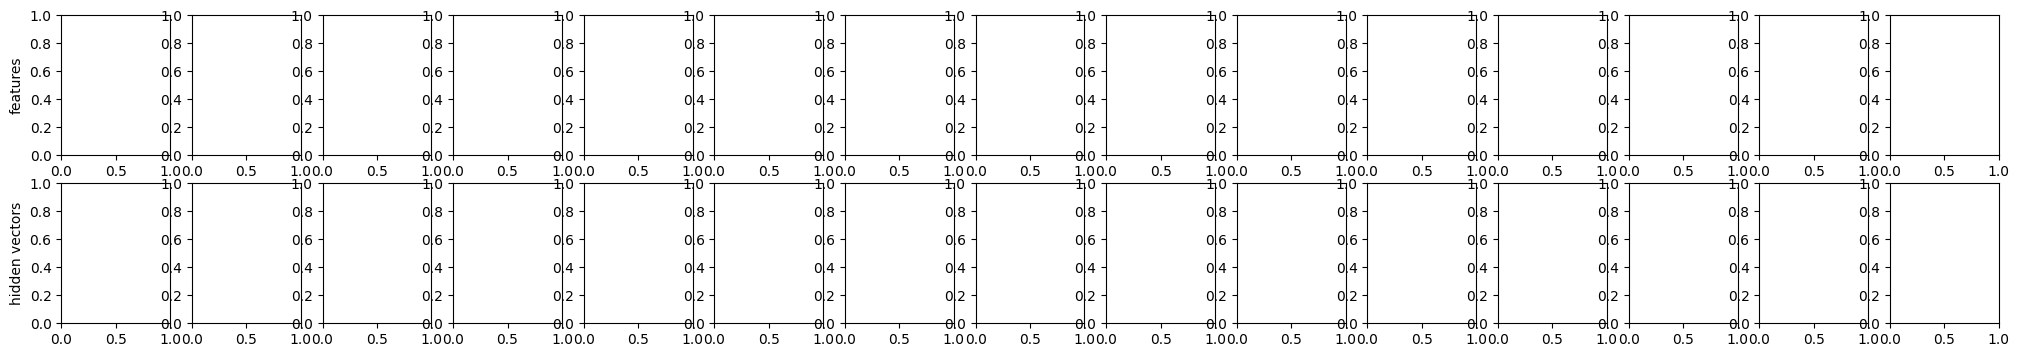

In [13]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data_sizes = [3, 5, 8, 10, 15, 30, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
c = 1.3  # scaling factor for plot limits

# Setup plotting
fig, ax = plt.subplots(2, len(data_sizes), figsize=(25, 4))
ax[0][0].set_ylabel("features")
ax[1][0].set_ylabel("hidden vectors")

hidden_vectors_list = []

for i in range(len(data_sizes)):
    # Get weights and inputs directly
    W = W  # The current W from your training loop
    inputs = inputs  # The current inputs from your training loop
    s = data_sizes[i]
    
    # Compute hidden vectors
    hidden_vectors = W @ inputs.T.float()
    hidden_vectors_list.append(hidden_vectors)
    
    # Plot features
    ax[0][i].scatter(W[0], W[1], color="blue", alpha=1)
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[0][i].set_xlim(c*W[0].min().item(), c*W[0].max().item())
    ax[0][i].set_ylim(c*W[1].min().item(), c*W[1].max().item())
    ax[0][i].set_title(str(s))
    ax[0][i].axvline(0, linestyle="--", color="grey", zorder=-1)
    ax[0][i].axhline(0, linestyle="--", color="grey", zorder=-1)
    
    # Plot hidden vectors
    ax[1][i].scatter(hidden_vectors[0], hidden_vectors[1], color="red", alpha=1)
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    ax[1][i].set_xlim(c*hidden_vectors[0].min().item(), c*hidden_vectors[0].max().item())
    ax[1][i].set_ylim(c*hidden_vectors[1].min().item(), c*hidden_vectors[1].max().item())
    ax[1][i].axvline(0, linestyle="--", color="grey", zorder=-1)
    ax[1][i].axhline(0, linestyle="--", color="grey", zorder=-1)

plt.tight_layout()
plt.show()

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def load_and_analyze_models(data_sizes, results_dir, timestamp):
    """
    Load saved models and analyze their dimensionality properties
    
    Args:
        data_sizes: List of dataset sizes used
        results_dir: Directory containing saved results
        timestamp: Timestamp used in filenames
    """
    results = []
    
    for size in data_sizes:
        # Load saved data
        train_data_path = f"{results_dir}/train_data_h{hidden_size}_d{depth}_n{size}_lr{lr}_{timestamp}.pt"
        model_path = f"{results_dir}/final_model_h{hidden_size}_d{depth}_n{size}_lr{lr}_{timestamp}.pt"
        
        train_data = torch.load(train_data_path)
        model_weights = torch.load(model_path)
        
        # Extract relevant components
        X = train_data['X'] 
        W = model_weights['W1']
        hidden_vectors = X @ W.T
        
        # Compute dimensionalities
        feature_dims = compute_dimensionality(W.T)
        data_dims = compute_dimensionality(hidden_vectors)
        
        results.append({
            'size': size,
            'feature_dims': feature_dims,
            'data_dims': data_dims,
            'W': W,
            'hidden_vectors': hidden_vectors
        })
    
    return results

def compute_dimensionality(W):
    """Compute dimensionality metric for each row of W"""
    norms = torch.linalg.norm(W, dim=1)
    W_norm = W / torch.clamp(norms.view(-1, 1), 1e-6, float('inf'))
    interference = torch.mm(W_norm, W_norm.T)**2 
    dims = norms**2 / interference.sum(1)
    return dims

def plot_dimensionality_analysis(results, save_path=None):
    """Create the dimensionality analysis plot"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), 
                                  gridspec_kw={'height_ratios': [1, 2]})
    
    sizes = [r['size'] for r in results]
    hidden_size = results[0]['W'].shape[0]
    
    # Plot test loss (top)
    test_losses = [r.get('test_loss', 1.0) for r in results]  # Default to 1.0 if missing
    ax1.plot(sizes, test_losses, '-o', color='black', alpha=0.8)
    ax1.axhline(1, linestyle='--', color='grey')
    ax1.set_xscale('log')
    ax1.set_ylabel('Test Loss')
    ax1.grid(True)
    
    # Plot dimensionalities (bottom)
    for r in results:
        # Plot feature dimensionalities
        feature_x = np.ones_like(r['feature_dims']) * r['size']
        ax2.scatter(feature_x, r['feature_dims'], color='blue', alpha=0.2, s=20)
        
        # Plot data dimensionalities
        data_x = np.ones_like(r['data_dims']) * r['size']
        ax2.scatter(data_x, r['data_dims'], color='red', alpha=0.2, s=20)
    
    # Add reference line
    ref_line = [hidden_size/size for size in sizes]
    ax2.plot(sizes, ref_line, '--', color='grey', alpha=0.8, 
             label='hidden size / dataset size')
    
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylim(0.00001, 1)
    ax2.set_xlabel('Dataset Size')
    ax2.set_ylabel('Fractional Dimension')
    ax2.legend(['Features', 'Hidden Vectors', 'Reference'])
    ax2.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    return fig

# Usage example:
if __name__ == "__main__":
    data_sizes = [3, 5, 8, 10, 15, 30, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results"
    timestamp = "20250101_171010"
    
    # Load and analyze models
    results = load_and_analyze_models(data_sizes, results_dir, timestamp)
    
    # Create plot
    plot_dimensionality_analysis(results, save_path="dimensionality_analysis.png")

NameError: name 'hidden_size' is not defined

Processing result: n_train=10, hidden_size=200
Processing result: n_train=50, hidden_size=200
Processing result: n_train=100, hidden_size=200
Processing result: n_train=200, hidden_size=200
Processing result: n_train=300, hidden_size=200
Processing result: n_train=400, hidden_size=200
Processing result: n_train=500, hidden_size=200
Processing result: n_train=800, hidden_size=200
Processing result: n_train=1000, hidden_size=200
Processing result: n_train=2500, hidden_size=200
Processing result: n_train=5000, hidden_size=200
Processing result: n_train=8000, hidden_size=200
Processing result: n_train=10000, hidden_size=200
Processing result: n_train=15000, hidden_size=200
Processing result: n_train=20000, hidden_size=200


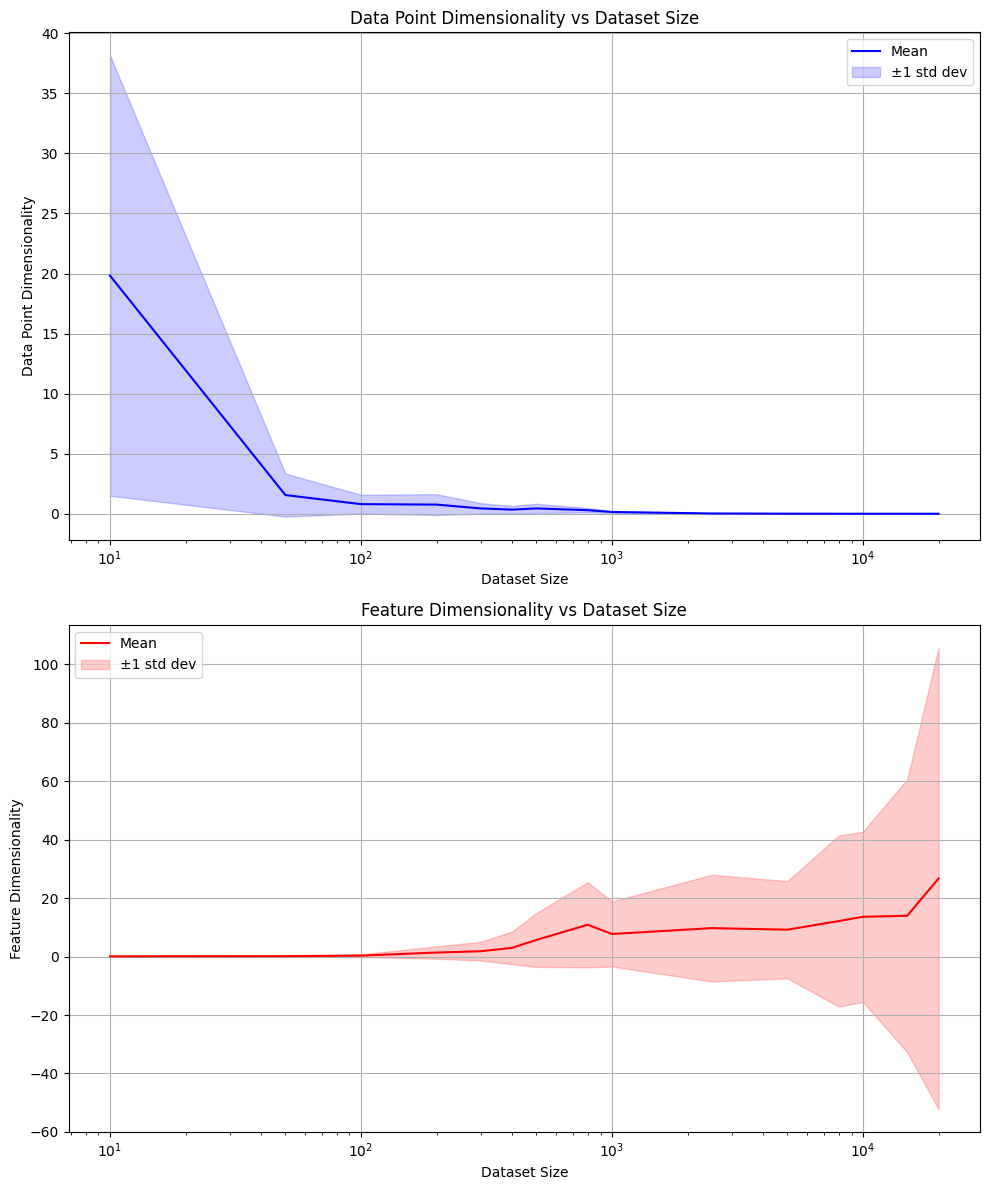

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

def compute_data_dimensionality(hidden: torch.Tensor) -> Tuple[float, float]:
    """Compute data point dimensionality: DXi = ||hi||^2 / sum_j(hi^·hj)^2"""
    with torch.no_grad():
        # Compute norms and normalize vectors
        norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized = hidden / (norms + 1e-8)
        
        # Compute pairwise dot products
        dots = normalized @ normalized.T
        
        # Compute dimensionality for each data point
        numerator = torch.sum(hidden * hidden, dim=1)  # ||hi||^2
        denominator = torch.sum(dots * dots, dim=1)  # sum_j(hi^·hj)^2
        
        dims = numerator / (denominator + 1e-8)
        
        return float(torch.mean(dims)), float(torch.std(dims))

def compute_feature_dimensionality(hidden: torch.Tensor) -> Tuple[float, float]:
    """Compute feature dimensionality using hidden dimensions as features"""
    with torch.no_grad():
        # Use hidden dimensions as features
        features = hidden.T  # Shape: (hidden_dim, n_samples)
        
        # Compute norms and normalize feature vectors
        norms = torch.norm(features, dim=1, keepdim=True)
        normalized = features / (norms + 1e-8)
        
        # Compute pairwise dot products between features
        dots = normalized @ normalized.T
        
        # Compute dimensionality for each feature
        numerator = torch.sum(features * features, dim=1)  # ||Wi||^2
        denominator = torch.sum(dots * dots, dim=1)  # sum_j(Wi^·Wj)^2
        
        dims = numerator / (denominator + 1e-8)
        
        return float(torch.mean(dims)), float(torch.std(dims))

def analyze_dimensionality(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute both dimensionality metrics"""
    with torch.no_grad():
        # Get hidden representations from last layer before output
        hidden = None
        for layer in model.network[:-1]:
            if hidden is None:
                hidden = layer(X)
            else:
                hidden = layer(hidden)
        
        # Compute data point dimensionality
        data_dim_mean, data_dim_std = compute_data_dimensionality(hidden)
        
        # Compute feature dimensionality
        feature_dim_mean, feature_dim_std = compute_feature_dimensionality(hidden)
        
        return {
            'data_dim_mean': data_dim_mean,
            'data_dim_std': data_dim_std,
            'feature_dim_mean': feature_dim_mean,
            'feature_dim_std': feature_dim_std
        }

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str):
    """Analyze metrics across different dataset sizes"""
    sorted_results = sorted(results, key=lambda x: x['n_train'])
    
    metrics = {
        'n_train': [],
        'data_dim_mean': [],
        'data_dim_std': [],
        'feature_dim_mean': [],
        'feature_dim_std': []
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, hidden_size={result['hidden_size']}")
        
        # Load model and data
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result)
        
        # Compute dimensionality metrics
        dims = analyze_dimensionality(model, X_train)
        
        # Store metrics
        metrics['n_train'].append(result['n_train'])
        metrics['data_dim_mean'].append(dims['data_dim_mean'])
        metrics['data_dim_std'].append(dims['data_dim_std'])
        metrics['feature_dim_mean'].append(dims['feature_dim_mean'])
        metrics['feature_dim_std'].append(dims['feature_dim_std'])
    
    return metrics

def plot_dimensionality_analysis(metrics: Dict):
    """Plot data and feature dimensionality with standard deviation bands"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Convert lists to numpy arrays
    n_train = np.array(metrics['n_train'])
    data_mean = np.array(metrics['data_dim_mean'])
    data_std = np.array(metrics['data_dim_std'])
    feature_mean = np.array(metrics['feature_dim_mean'])
    feature_std = np.array(metrics['feature_dim_std'])
    
    # Plot data point dimensionality
    ax1.plot(n_train, data_mean, 'b-', label='Mean')
    ax1.fill_between(n_train, 
                    data_mean - data_std, 
                    data_mean + data_std, 
                    alpha=0.2, 
                    color='blue',
                    label='±1 std dev')
    ax1.set_xlabel('Dataset Size')
    ax1.set_ylabel('Data Point Dimensionality')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.legend()
    ax1.set_title('Data Point Dimensionality vs Dataset Size')

    # Plot feature dimensionality
    ax2.plot(n_train, feature_mean, 'r-', label='Mean')
    ax2.fill_between(n_train, 
                    feature_mean - feature_std, 
                    feature_mean + feature_std, 
                    alpha=0.2, 
                    color='red',
                    label='±1 std dev')
    ax2.set_xlabel('Dataset Size')
    ax2.set_ylabel('Feature Dimensionality')
    ax2.set_xscale('log')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Feature Dimensionality vs Dataset Size')

    plt.tight_layout()
    return fig

def main():
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro"
    data_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro"
    timestamp = "20250101_171010"
    
    # Load data
    results, hyperparams = load_experiment_data(results_dir, timestamp)
    
    # Analyze metrics
    metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir)
    
    # Create plots
    fig = plot_dimensionality_analysis(metrics)
    plt.show()

if __name__ == "__main__":
    main()

Processing result: n_train=10, hidden_size=200
Processing result: n_train=50, hidden_size=200
Processing result: n_train=100, hidden_size=200
Processing result: n_train=200, hidden_size=200
Processing result: n_train=300, hidden_size=200
Processing result: n_train=400, hidden_size=200
Processing result: n_train=500, hidden_size=200
Processing result: n_train=800, hidden_size=200
Processing result: n_train=1000, hidden_size=200
Processing result: n_train=2500, hidden_size=200
Processing result: n_train=5000, hidden_size=200
Processing result: n_train=8000, hidden_size=200
Processing result: n_train=10000, hidden_size=200
Processing result: n_train=15000, hidden_size=200
Processing result: n_train=20000, hidden_size=200


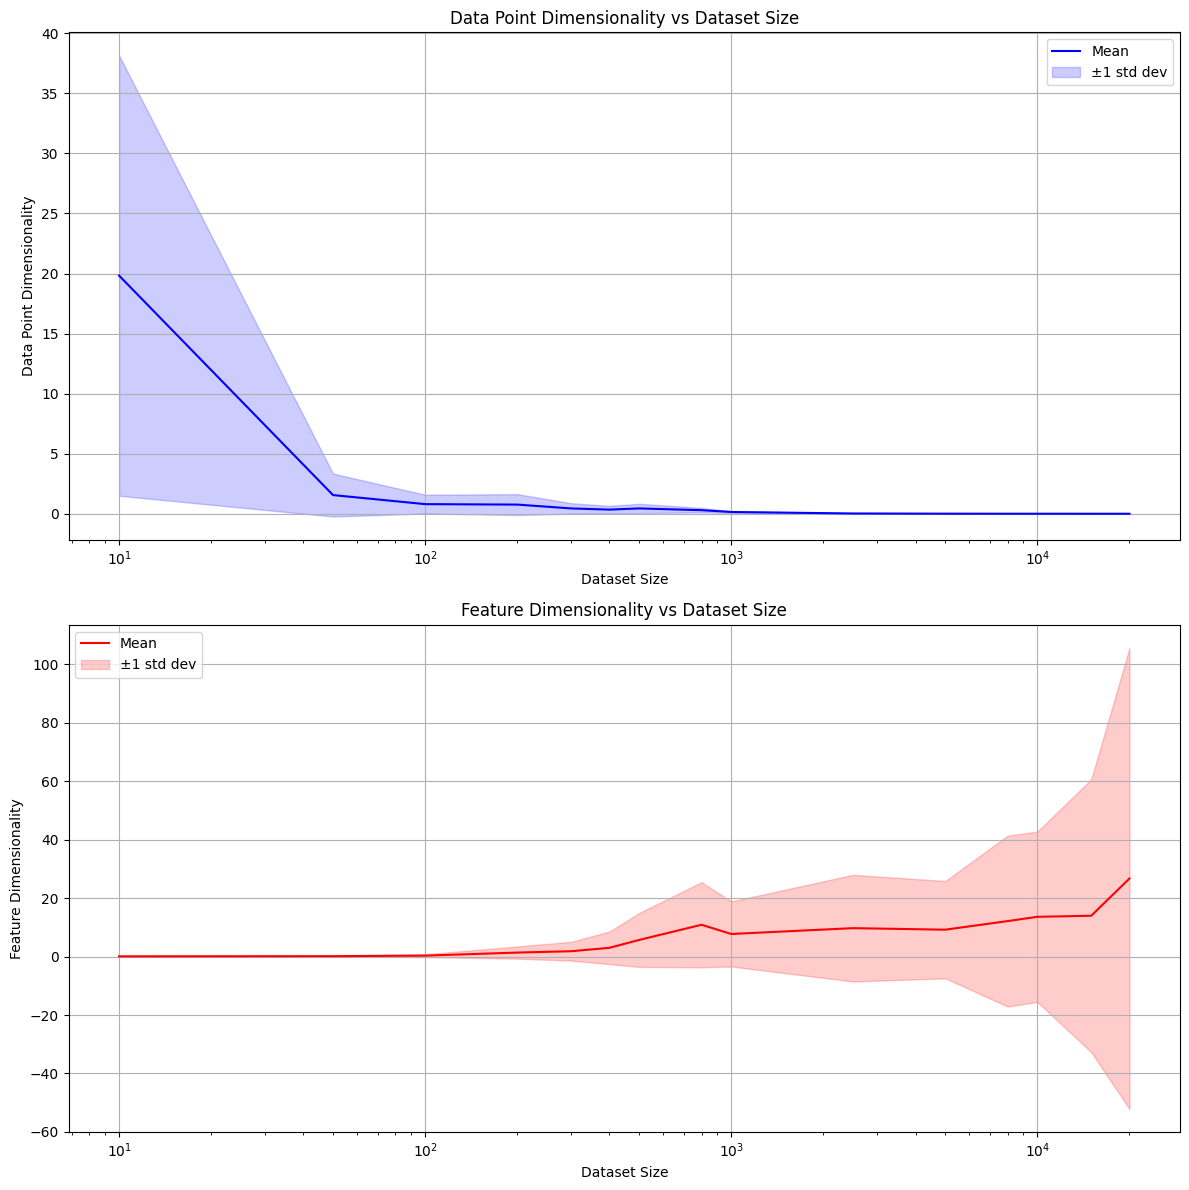

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

def compute_dimensionality(model: torch.nn.Module, X: torch.Tensor) -> Tuple[float, float, float, float]:
    """Compute both data point and feature dimensionality using last layer activations
    Returns (data_dim_mean, data_dim_std, feature_dim_mean, feature_dim_std)
    """
    with torch.no_grad():
        # Get last layer activations
        hidden = None
        for layer in model.network[:-1]:
            if hidden is None:
                hidden = layer(X)
            else:
                hidden = layer(hidden)
        
        # Data point dimensionality
        # Each row of hidden is a data point: (batch_size, hidden_dim)
        data_norms = torch.norm(hidden, dim=1, keepdim=True)  # (batch_size, 1)
        normalized_data = hidden / (data_norms + 1e-8)  # (batch_size, hidden_dim)
        
        # For each data point, compute squared norm / sum of squared cosine similarities
        data_dots = (normalized_data @ normalized_data.T) ** 2  # (batch_size, batch_size)
        data_dims = torch.sum(hidden ** 2, dim=1) / (torch.sum(data_dots, dim=1) + 1e-8)
        
        # Feature dimensionality
        # Each column of hidden is a feature: (batch_size, hidden_dim)
        features = hidden.T  # (hidden_dim, batch_size)
        feature_norms = torch.norm(features, dim=1, keepdim=True)  # (hidden_dim, 1)
        normalized_features = features / (feature_norms + 1e-8)  # (hidden_dim, batch_size)
        
        # For each feature, compute squared norm / sum of squared cosine similarities
        feature_dots = (normalized_features @ normalized_features.T) ** 2  # (hidden_dim, hidden_dim)
        feature_dims = torch.sum(features ** 2, dim=1) / (torch.sum(feature_dots, dim=1) + 1e-8)
        
        return (float(torch.mean(data_dims)), float(torch.std(data_dims)),
                float(torch.mean(feature_dims)), float(torch.std(feature_dims)))

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str):
    """Analyze metrics across different dataset sizes"""
    sorted_results = sorted(results, key=lambda x: x['n_train'])
    
    metrics = {
        'n_train': [],
        'data_dim_mean': [],
        'data_dim_std': [],
        'feature_dim_mean': [],
        'feature_dim_std': []
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, hidden_size={result['hidden_size']}")
        
        # Load model and data
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result)
        
        # Compute dimensionality metrics
        data_mean, data_std, feature_mean, feature_std = compute_dimensionality(model, X_train)
        
        # Store metrics
        metrics['n_train'].append(result['n_train'])
        metrics['data_dim_mean'].append(data_mean)
        metrics['data_dim_std'].append(data_std)
        metrics['feature_dim_mean'].append(feature_mean)
        metrics['feature_dim_std'].append(feature_std)
    
    return metrics

def plot_dimensionality_analysis(metrics: Dict):
    """Plot dimensionality analysis with standard deviation bands"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Convert lists to numpy arrays
    n_train = np.array(metrics['n_train'])
    data_mean = np.array(metrics['data_dim_mean'])
    data_std = np.array(metrics['data_dim_std'])
    feature_mean = np.array(metrics['feature_dim_mean'])
    feature_std = np.array(metrics['feature_dim_std'])
    
    # Plot data point dimensionality
    ax1.plot(n_train, data_mean, 'b-', label='Mean')
    ax1.fill_between(n_train, 
                    data_mean - data_std, 
                    data_mean + data_std, 
                    alpha=0.2, 
                    color='blue',
                    label='±1 std dev')
    ax1.set_xlabel('Dataset Size')
    ax1.set_ylabel('Data Point Dimensionality')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.legend()
    ax1.set_title('Data Point Dimensionality vs Dataset Size')
    
    # Plot feature dimensionality
    ax2.plot(n_train, feature_mean, 'r-', label='Mean')
    ax2.fill_between(n_train, 
                    feature_mean - feature_std, 
                    feature_mean + feature_std, 
                    alpha=0.2, 
                    color='red',
                    label='±1 std dev')
    ax2.set_xlabel('Dataset Size')
    ax2.set_ylabel('Feature Dimensionality')
    ax2.set_xscale('log')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Feature Dimensionality vs Dataset Size')
    
    plt.tight_layout()
    return fig

def main():
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro"
    data_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro"
    timestamp = "20250101_171010"
    
    # Load data
    results, hyperparams = load_experiment_data(results_dir, timestamp)
    
    # Analyze metrics
    metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir)
    
    # Create plots
    fig = plot_dimensionality_analysis(metrics)
    plt.show()

if __name__ == "__main__":
    main()

In [6]:
def plot_dimensionality_analysis(dim_acts_list, data_sizes, save_path=None):
    """Plot dimensionality analysis results in three separate plots"""
    
    # Create three subplots - one combined, one for features, one for hidden
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), dpi=120)
    
    # Get hidden size from first model's activations shape
    hidden_size = dim_acts_list[0].shape[0]
    hidden_data_ratios = hidden_size / np.array(data_sizes)
    
    # Combined plot
    ax1.set_ylabel("fractional dimension")
    ax1.set_xlabel("dataset size")
    
    # Plot features in blue and hidden in red
    for i, size in enumerate(data_sizes):
        # Hidden vectors (red)
        ax1.scatter(np.ones(len(dim_acts_list[i])) * size,
                  dim_acts_list[i].numpy(),
                  color="red", alpha=0.2, s=20, label="hidden" if i == 0 else "")
    
    ax1.plot(data_sizes, hidden_data_ratios, '-o', 
            color="grey", alpha=0.8, linestyle="--", 
            label="hidden size / dataset size")
    
    ax1.set_xscale("log")
    ax1.legend()
    ax1.set_xticks(data_sizes)
    ax1.set_xticklabels(data_sizes)
    ax1.set_ylim(0, 0.3)
    ax1.set_title("Combined Dimensionality Analysis")
    
    # Hidden vectors only plot
    ax2.set_ylabel("fractional dimension")
    ax2.set_xlabel("dataset size")
    
    for i, size in enumerate(data_sizes):
        ax2.scatter(np.ones(len(dim_acts_list[i])) * size,
                  dim_acts_list[i].numpy(),
                  color="red", alpha=0.2, s=20)
    
    ax2.plot(data_sizes, hidden_data_ratios, '-o', 
            color="grey", alpha=0.8, linestyle="--", 
            label="hidden size / dataset size")
    
    ax2.set_xscale("log")
    ax2.legend()
    ax2.set_xticks(data_sizes)
    ax2.set_xticklabels(data_sizes)
    ax2.set_ylim(0, 0.3)
    ax2.set_title("Hidden Vector Dimensionality")
    
    # Feature dimensionality plot
    ax3.set_ylabel("fractional dimension")
    ax3.set_xlabel("dataset size")
    
    for i, size in enumerate(data_sizes):
        feature_dims = compute_feature_dimensionality(dim_acts_list[i])
        ax3.scatter(np.ones(len(feature_dims)) * size,
                   feature_dims.numpy(),
                   color="blue", alpha=0.2, s=20)
    
    ax3.set_xscale("log")
    ax3.legend()
    ax3.set_xticks(data_sizes)
    ax3.set_xticklabels(data_sizes)
    ax3.set_ylim(0, 0.3)
    ax3.set_title("Feature Dimensionality")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

def compute_feature_dimensionality(hidden_dims):
    """Compute feature dimensionality from hidden dimensionality"""
    # This should be implemented based on how you want to calculate feature dimensionality
    # For now, returning placeholder
    return hidden_dims  # Replace with actual computation

# Modification to main analysis function to compute both metrics
def analyze_saved_models(results_dir: str, timestamp: str):
    """Analyze dimensionality of saved models"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load final results
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    # Group results by n_train
    results_by_size = {}
    for result in results:
        n_train = result['n_train']
        if n_train not in results_by_size:
            results_by_size[n_train] = []
        results_by_size[n_train].append(result)
    
    data_sizes = sorted(list(results_by_size.keys()))
    dim_acts_list = []
    
    # Process each training size
    for n_train in data_sizes:
        print(f"\nProcessing models for training size {n_train}")
        size_results = results_by_size[n_train]
        
        # Process each model for this size separately
        for result in size_results:
            # Load this specific model's data and model
            train_data_path = os.path.join(results_dir, result['train_data_path'])
            model_path = os.path.join(results_dir, result['final_model_path'])
            
            # Load model
            hidden_size = result['hidden_size']
            depth = result['depth']
            model = DeepNN(d=30, hidden_size=hidden_size, depth=depth).to(device)
            model.load_state_dict(torch.load(model_path))
            model.eval()
            
            # Load the exact training data used for this model
            try:
                train_data = torch.load(train_data_path)
                X_train = train_data['X'].to(device)
                print(f"Loaded training data shape: {X_train.shape}")
            except Exception as e:
                print(f"Error loading training data from {train_data_path}: {e}")
                continue
            
            # Get activations using this model's specific training data
            with torch.no_grad():
                activations = model.get_activations(X_train)
                print(f"Generated activations shape: {activations.shape}")
            
            # Compute dimensionality
            dim_acts = compute_dimensionality2(activations)
            dim_acts_list.append(dim_acts)
    
    return dim_acts_list, data_sizes
if __name__ == "__main__":
    # Set paths
    base_dir = "/mnt/users/goringn/NNs_vs_Kernels"
    experiment_name = "msp_NN_grid_3012_antro"
    results_dir = os.path.join(base_dir, "stair_function/results", experiment_name)
    
    # You'll need to provide the timestamp from your training run
    timestamp = "20250101_171010"  # Replace with actual timestamp
    
    print(f"Analyzing models in: {results_dir}")
    
    # Run analysis
    dim_acts_list, data_sizes = analyze_saved_models(results_dir, timestamp)
    
    # Plot results
    save_path = os.path.join(results_dir, f'dimensionality_analysis_{timestamp}.png')
    plot_dimensionality_analysis(dim_acts_list, data_sizes, save_path)

Analyzing models in: /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro
Using device: cpu

Processing models for training size 10
Loaded training data shape: torch.Size([10, 30])


/tmp/ipykernel_3767838/1790846608.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_3767838/1790846608.py:12

AttributeError: 'DeepNN' object has no attribute 'get_activations'

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from typing import Dict, List, Tuple
from datetime import datetime

# Model definition - must match training architecture
class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

# Set paths
base_dir = "/mnt/users/goringn/NNs_vs_Kernels"
results_dir = os.path.join(base_dir, "stair_function/results/msp_NN_grid_3012_antro")

# Function to compute dimensionality for a single model
def compute_model_dimensionality(model_path: str, data_path: str, d: int = 30) -> Dict:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Extract model architecture from filename
    parts = os.path.basename(model_path).split('_')
    hidden_size = int(parts[2][1:])
    depth = int(parts[3][1:])
    
    # Initialize model and load weights
    model = DeepNN(d=d, hidden_size=hidden_size, depth=depth).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    # Load data
    data = torch.load(data_path, map_location=device)
    X = data['X'].to(device)
    
    # Get activations and compute dimensionality
    layer_metrics = []
    activations = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output
        return hook
    
    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            hooks.append(module.register_forward_hook(get_activation(name)))
    
    # Forward pass
    with torch.no_grad():
        _ = model(X)
    
    # Compute metrics for each layer
    for name, activation in activations.items():
        layer = dict(model.named_modules())[name]
        
        # Sample dimensionality
        hidden_norms = torch.norm(activation, dim=1, keepdim=True)
        normalized_hidden = activation / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ normalized_hidden.T
        sample_dims = torch.sum(activation * activation, dim=1) / (torch.sum(hidden_dots * hidden_dots, dim=1) + 1e-8)
        
        # Feature dimensionality
        weights = layer.weight
        feature_norms = torch.norm(weights, dim=1, keepdim=True)
        normalized_features = weights / (feature_norms + 1e-8)
        feature_dots = normalized_features @ normalized_features.T
        feature_dims = torch.sum(weights * weights, dim=1) / (torch.sum(feature_dots * feature_dots, dim=1) + 1e-8)
        
        layer_metrics.append({
            'layer_name': name,
            'mean_sample_dim': float(torch.mean(sample_dims)),
            'sample_dims': sample_dims.cpu().numpy().tolist(),
            'mean_feature_dim': float(torch.mean(feature_dims)),
            'feature_dims': feature_dims.cpu().numpy().tolist(),
        })
    
    # Clean up hooks
    for hook in hooks:
        hook.remove()
        
    return layer_metrics

# List all available files
print("Data files in directory:")
data_files = [f for f in os.listdir(results_dir) if f.startswith('train_data_')]
for f in data_files[:5]:  # Show first 5 files
    print(f)

print("\nModel files in directory:")
model_files = [f for f in os.listdir(results_dir) if f.startswith('final_model_')]
for f in model_files[:5]:  # Show first 5 files
    print(f)

# Analyze all models
all_results = []
for model_file in model_files:
    print(f"\nProcessing {model_file}")
    parts = model_file.split('_')
    hidden_size = parts[2][1:]
    depth = parts[3][1:]
    n_train = parts[4][1:]
    lr = parts[5][2:]
    mode = 'mup_pennington'  # from your training code
    timestamp = '20250101_171010'
    
    # Construct data path
    data_filename = f'train_data_h{hidden_size}_d{depth}_n{n_train}_lr{lr}_{mode}_{timestamp}_rank{parts[-1].split(".")[0]}.pt'
    data_path = os.path.join(results_dir, data_filename)
    model_path = os.path.join(results_dir, model_file)
    
    print(f"Looking for data file: {data_filename}")
    
    if os.path.exists(data_path) and os.path.exists(model_path):
        try:
            metrics = compute_model_dimensionality(model_path, data_path)
            all_results.append({
                'n_train': int(n_train),
                'hidden_size': int(hidden_size),
                'metrics': metrics
            })
            print(f"Successfully processed n_train={n_train}")
        except Exception as e:
            print(f"Error processing model: {str(e)}")
    else:
        print("Model or data file not found")

if all_results:
    # Plot dimensionality vs dataset size
    sorted_results = sorted(all_results, key=lambda x: x['n_train'])
    n_trains = [r['n_train'] for r in sorted_results]
    sample_dims = [np.mean([l['mean_sample_dim'] for l in r['metrics']]) for r in sorted_results]
    feature_dims = [np.mean([l['mean_feature_dim'] for l in r['metrics']]) for r in sorted_results]

    plt.figure(figsize=(12, 6))
    plt.semilogx(n_trains, sample_dims, 'r-', label='Sample Dimensionality')
    plt.semilogx(n_trains, feature_dims, 'b-', label='Feature Dimensionality')
    plt.grid(True)
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Dimensionality')
    plt.title('Dimensionality vs Dataset Size')
    plt.legend()
    plt.show()

    # Save results
    results_path = os.path.join(base_dir, 'dimensionality_analysis_results.json')
    print(f"\nSaving results to {results_path}")
    with open(results_path, 'w') as f:
        json.dump(all_results, f, indent=4)
else:
    print("No results were generated. Check the error messages above.")

Data files in directory:
train_data_h200_d4_n500_lr0.05_20250101_171010_rank8.pt
train_data_h200_d4_n15000_lr0.05_20250101_171010_rank1.pt
train_data_h200_d4_n800_lr0.05_20250101_171010_rank7.pt
train_data_h200_d4_n200_lr0.05_20250101_171010_rank11.pt
train_data_h200_d4_n100_lr0.05_20250101_171010_rank0.pt

Model files in directory:
final_model_h200_d4_n2500_lr0.05_mup_pennington_20250101_171010_rank5.pt
final_model_h200_d4_n500_lr0.05_mup_pennington_20250101_171010_rank8.pt
final_model_h200_d4_n800_lr0.05_mup_pennington_20250101_171010_rank7.pt
final_model_h200_d4_n8000_lr0.05_mup_pennington_20250101_171010_rank3.pt
final_model_h200_d4_n10_lr0.05_mup_pennington_20250101_171010_rank2.pt

Processing final_model_h200_d4_n2500_lr0.05_mup_pennington_20250101_171010_rank5.pt
Looking for data file: train_data_h200_d4_n2500_lr0.05_mup_pennington_20250101_171010_rankrank5.pt
Model or data file not found

Processing final_model_h200_d4_n500_lr0.05_mup_pennington_20250101_171010_rank8.pt
Looking

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from typing import Dict, List, Tuple
from datetime import datetime

# Model definition - must match training architecture
class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def compute_model_dimensionality(model_path: str, data_path: str, d: int = 30) -> Dict:
    """Analyze dimensionality metrics for a specific model checkpoint"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Extract model architecture from filename
    parts = os.path.basename(model_path).split('_')
    hidden_size = int(parts[2][1:])
    depth = int(parts[3][1:])
    
    # Initialize model and load weights
    model = DeepNN(d=d, hidden_size=hidden_size, depth=depth).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    # Load data
    data = torch.load(data_path, map_location=device)
    X = data['X'].to(device)
    
    # Get activations and compute dimensionality
    layer_metrics = []
    activations = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output
        return hook
    
    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            hooks.append(module.register_forward_hook(get_activation(name)))
    
    # Forward pass
    with torch.no_grad():
        _ = model(X)
    
    # Compute metrics for each layer
    for name, activation in activations.items():
        layer = dict(model.named_modules())[name]
        
        # Sample dimensionality
        hidden_norms = torch.norm(activation, dim=1, keepdim=True)
        normalized_hidden = activation / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ normalized_hidden.T
        sample_dims = torch.sum(activation * activation, dim=1) / (torch.sum(hidden_dots * hidden_dots, dim=1) + 1e-8)
        
        # Feature dimensionality
        weights = layer.weight
        feature_norms = torch.norm(weights, dim=1, keepdim=True)
        normalized_features = weights / (feature_norms + 1e-8)
        feature_dots = normalized_features @ normalized_features.T
        feature_dims = torch.sum(weights * weights, dim=1) / (torch.sum(feature_dots * feature_dots, dim=1) + 1e-8)
        
        layer_metrics.append({
            'layer_name': name,
            'mean_sample_dim': float(torch.mean(sample_dims)),
            'sample_dims': sample_dims.cpu().numpy().tolist(),
            'mean_feature_dim': float(torch.mean(feature_dims)),
            'feature_dims': feature_dims.cpu().numpy().tolist(),
        })
    
    # Clean up hooks
    for hook in hooks:
        hook.remove()
        
    return layer_metrics

def main():
    # Set paths
    base_dir = "/mnt/users/goringn/NNs_vs_Kernels"
    results_dir = os.path.join(base_dir, "stair_function/results/msp_NN_grid_3012_antro")
    timestamp = "20250101_171010"
    mode = "mup_pennington"

    # Get all files
    print("Loading files from:", results_dir)
    all_files = os.listdir(results_dir)
    model_files = [f for f in all_files if f.startswith('final_model_')]
    data_files = [f for f in all_files if f.startswith('train_data_')]
    
    print(f"\nFound {len(model_files)} model files and {len(data_files)} data files")
    
    # Analyze all models
    all_results = []
    for model_file in model_files:
        print(f"\nProcessing {model_file}")
        parts = model_file.split('_')
        hidden_size = parts[2][1:]
        depth = parts[3][1:]
        n_train = parts[4][1:]
        lr = parts[5][2:]
        
        # Find matching data file (any rank)
        data_pattern = f'train_data_h{hidden_size}_d{depth}_n{n_train}_lr{lr}_{mode}_{timestamp}_rank'
        matching_data = [f for f in data_files if data_pattern in f]
        
        if matching_data:
            data_path = os.path.join(results_dir, matching_data[0])
            model_path = os.path.join(results_dir, model_file)
            
            print(f"Found matching data file: {matching_data[0]}")
            
            try:
                metrics = compute_model_dimensionality(model_path, data_path)
                all_results.append({
                    'n_train': int(n_train),
                    'hidden_size': int(hidden_size),
                    'metrics': metrics
                })
                print(f"Successfully processed model with n_train={n_train}")
            except Exception as e:
                print(f"Error processing model: {str(e)}")
                continue
        else:
            print(f"No matching data file found for pattern: {data_pattern}")

    if all_results:
        # Plot dimensionality vs dataset size for each hidden size
        plt.figure(figsize=(12, 6))
        
        # Group by hidden size
        hidden_sizes = sorted(set(r['hidden_size'] for r in all_results))
        for hidden_size in hidden_sizes:
            # Filter and sort results for this hidden size
            hidden_results = sorted(
                [r for r in all_results if r['hidden_size'] == hidden_size],
                key=lambda x: x['n_train']
            )
            
            n_trains = [r['n_train'] for r in hidden_results]
            sample_dims = [np.mean([l['mean_sample_dim'] for l in r['metrics']]) for r in hidden_results]
            feature_dims = [np.mean([l['mean_feature_dim'] for l in r['metrics']]) for r in hidden_results]
            
            plt.semilogx(n_trains, sample_dims, 'r-', label=f'Sample Dim (h={hidden_size})')
            plt.semilogx(n_trains, feature_dims, 'b--', label=f'Feature Dim (h={hidden_size})')
        
        plt.grid(True)
        plt.xlabel('Training Set Size')
        plt.ylabel('Mean Dimensionality')
        plt.title('Dimensionality vs Dataset Size')
        plt.legend()
        plt.show()

        # Save results
        results_path = os.path.join(base_dir, f'dimensionality_analysis_{timestamp}.json')
        print(f"\nSaving results to {results_path}")
        with open(results_path, 'w') as f:
            json.dump(all_results, f, indent=4)
        print("Analysis complete!")
    else:
        print("No results were generated. Check the error messages above.")

if __name__ == "__main__":
    main()

Loading files from: /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro

Found 15 model files and 15 data files

Processing final_model_h200_d4_n2500_lr0.05_mup_pennington_20250101_171010_rank5.pt
No matching data file found for pattern: train_data_h200_d4_n2500_lr0.05_mup_pennington_20250101_171010_rank

Processing final_model_h200_d4_n500_lr0.05_mup_pennington_20250101_171010_rank8.pt
No matching data file found for pattern: train_data_h200_d4_n500_lr0.05_mup_pennington_20250101_171010_rank

Processing final_model_h200_d4_n800_lr0.05_mup_pennington_20250101_171010_rank7.pt
No matching data file found for pattern: train_data_h200_d4_n800_lr0.05_mup_pennington_20250101_171010_rank

Processing final_model_h200_d4_n8000_lr0.05_mup_pennington_20250101_171010_rank3.pt
No matching data file found for pattern: train_data_h200_d4_n8000_lr0.05_mup_pennington_20250101_171010_rank

Processing final_model_h200_d4_n10_lr0.05_mup_pennington_20250101_171010_rank2.pt
No ma